# 第7章 现代卷积神经网络

## 7.1 深度卷积神经网络(AlexNet)

&emsp;&emsp;在本节练习中，我们分别用到了两种网络，分别是AlexNet以及LeNet，在进入练习之前，我们先给出两个模型的网络结构（此处只列举网络的层次结构，具体的网络定义我们封装在`models.py`文件当中）：\
&emsp;&emsp;首先对于AlexNet，其结构如下：


<img src = ..\..\images\ch07_1_1_alexnet.png style="zoom:20%" title="AlexNet网络结构">


```python
class AlexNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
       super().__init__()
       self.in_channels = in_channels
       self.num_classes = num_classes
       self.net = nn.Sequential(
                    # 这里使用一个11*11的更大窗口来捕捉对象。
                    # 同时，步幅为4，以减少输出的高度和宽度。
                    # 另外，输出通道的数目远大于LeNet
                    nn.Conv2d(self.in_channels, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
                    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    # 使用三个连续的卷积层和较小的卷积窗口。
                    # 除了最后的卷积层，输出通道的数量进一步增加。
                    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
                    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
                    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
                    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    nn.Flatten(),
                    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
                    nn.Linear(6400, 4096), nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(4096, 4096), nn.ReLU(),
                    nn.Dropout(p=0.5),
                    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
                    nn.Linear(4096, self.num_classes))
    
    def forward(self, x):
        return self.net(x)
```
&emsp;&emsp;而对于LeNet，其仅仅由简单的七层网络构成，其代码结构为：
```python
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.net = nn.Sequential(nn.Conv2d(self.in_channels, 6, kernel_size=5, padding=2), 
                              nn.Sigmoid(),
                              nn.AvgPool2d(kernel_size=2, stride=2),
                              nn.Conv2d(6, 16, kernel_size=5), 
                              nn.Sigmoid(),
                              nn.AvgPool2d(kernel_size=2, stride=2),
                              nn.Flatten(),
                              nn.Linear(16 * 5 * 5, 120), 
                              nn.Sigmoid(),
                              nn.Linear(120, 84),
                              nn.Sigmoid(),
                              nn.Linear(84, self.num_classes))
        
    def forward(self, x):
        return self.net(x)
```

### 练习 7.1.1

试着增加迭代轮数。对比LeNet的结果有什么不同？为什么？

**解答：**

&emsp;&emsp;首先导入必要的包，定义模型训练与记录的函数。

In [5]:
import torch
# utlis中定义了部分数据集的加载代码，以及记录csv的代码
from utlis import *
# models中定义了整个第七章中使用到的模型
import models
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import os

# 定义数据存储位置
pth = '../data/ch07_output/'

# 定义模型训练的函数
def train_models(net, # 网络
                 train_loader, # 训练集 
                 test_loader, # 测试集
                 epochs, # 训练轮数
                 lr, # 学习率
                 net_type : str =  None, # 网络类型，方便记录
                 device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    # 设置优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 设置损失函数
    loss = nn.CrossEntropyLoss()
    
    # 初始化参数
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    
    # 记录数据
    epoch_list = []
    train_loss = []
    train_acc = []
    test_acc = []
        
    for epoch in range(epochs):
    # 训练阶段
        loss_sum = 0
        acc = 0
        net.train()
        for idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predict = net(x)
            l = loss(predict, y)
            l.backward()
            optimizer.step()
            # 打印损失和准确率
            loss_sum += l.item() * x.size(0)
            acc += predict.max(dim=1)[1].eq(y).sum().item()
            if (idx + 1) % (len(train_loader) // 5) == 0 or idx == len(train_loader) - 1:
                if (idx + 1) != len(train_loader):
                    loss_now = loss_sum / (idx + 1) / x.size(0)
                    acc_now = acc / (idx + 1) / x.size(0)
                else:
                    loss_now = loss_sum / len(train_loader.dataset)
                    acc_now = acc / len(train_loader.dataset)
                # 记录数据
                train_acc.append(acc_now)
                train_loss.append(loss_now)
                epoch_list.append(epoch + (idx + 1) / len(train_loader))         
    
        # 测试
        loss_sum = 0
        acc = 0
        # 将模型设置为测试模式
        net.eval()
        with torch.no_grad():
            for idx, (x, y) in enumerate(test_loader):
                
                    x, y = x.to(device), y.to(device)
                    predict = net(x)
                    l = loss(predict, y)
                    
                    acc += predict.max(dim=1)[1].eq(y).sum().item()
                
            acc /= len(test_loader.dataset)
            test_acc.append(acc)
    
    epoch_test = list(range(1, int(epoch_list[-1]) + 1, 1))
    
    # 记录数据
    if net_type is not None: 
        pth_csv1 = os.path.join(pth, 'ch7_01.csv')
        pth_csv2 = os.path.join(pth, 'ch7_01_eval.csv')
        # 写入csv文件
        write2csv(pth_csv1, epoch_list, net_type + '_epoch_train')
        write2csv(pth_csv1, train_loss, net_type + '_train_loss')
        write2csv(pth_csv1, train_acc, net_type + '_train_acc')
        write2csv(pth_csv2, epoch_test, net_type + '_epoch_test')
        write2csv(pth_csv2, test_acc, net_type + '_test_acc')
    else:
        print('net_type is None, don\'t record the data')


&emsp;&emsp;定义网络，加载数据集

In [ ]:
AlexNet = models.AlexNet()
LeNet = models.LeNet()
train_loader, test_loader = load_data_fashion_mnist(batch_size=128)

&emsp;&emsp;LeNet模型，在上一章节中LeNet模型所用的学习率为0.9，在本章习题中继续沿用0.9。学习率为0.01模型无法收敛。

In [ ]:
train_models(LeNet, train_loader, test_loader, epochs=50, lr=0.9, net_type='LeNet')

&emsp;&emsp;加载AlexNet数据集，AlexNet一般使用输入为224*224的图片大小去进行训练

In [ ]:
train_loader, test_loader = load_data_fashion_mnist(batch_size=128, resize=224)
train_models(AlexNet, train_loader, test_loader, epochs=50, lr=0.01, net_type='AlexNet')

&emsp;&emsp;提醒一点，以上两个cell的运行时间会较长（约40min）。\
&emsp;&emsp;根据得到csv文件，绘制图像观察对比如下：

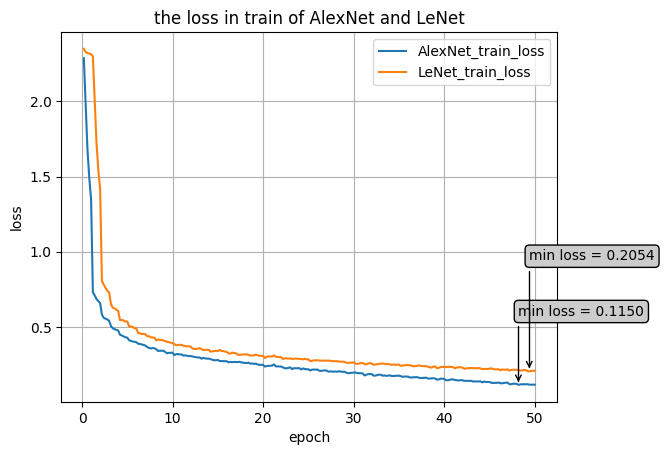

In [4]:
# 读取文件，得到记录数据
draw_figures(pth = os.path.join(pth, 'ch7_01.csv'),
             label_list=[('AlexNet_epoch_train', 'AlexNet_train_loss'), 
                         ('LeNet_epoch_train', 'LeNet_train_loss')],
             title='the loss in train of AlexNet and LeNet')


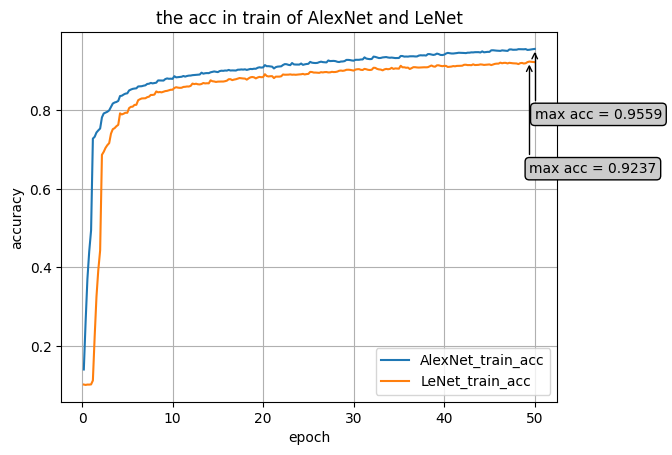

In [5]:
draw_figures(pth = os.path.join(pth, 'ch7_01.csv'),
             label_list=[('AlexNet_epoch_train', 'AlexNet_train_acc'), 
                         ('LeNet_epoch_train', 'LeNet_train_acc')],
             title='the acc in train of AlexNet and LeNet')

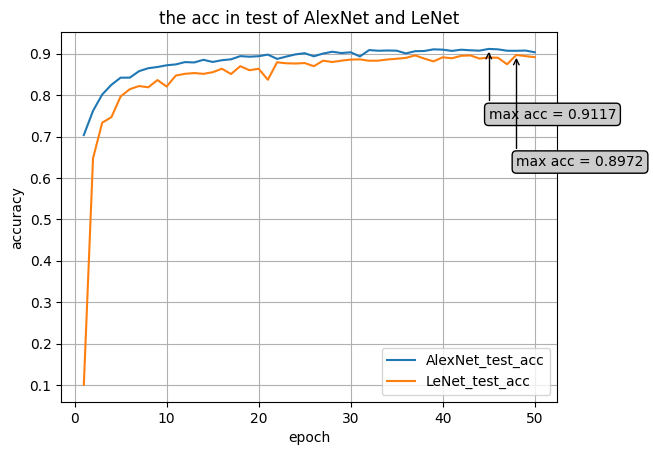

In [6]:
draw_figures(pth = os.path.join(pth, 'ch7_01_eval.csv'),
             label_list=[('AlexNet_epoch_test', 'AlexNet_test_acc'), 
                         ('LeNet_epoch_test', 'LeNet_test_acc')],
             title='the acc in test of AlexNet and LeNet')

&emsp;&emsp;综上所述，我们可以得到如下：

&emsp;&emsp;1. AlexNet整体上比LeNet有更高的训练和测试准确率，这说明AlexNet模型更加高效,有更强的拟合能力；

&emsp;&emsp;2. 随着epoch的增加，两种模型的训练准确率和测试准确率均有不同程度的提高，但AlexNet的提高速度更快，这再次说明AlexNet模型更强大；

&emsp;&emsp;3. AlexNet的训练准确率和测试准确率的差距较小，这说明AlexNet有更好的泛化能力，较少过拟合，而LeNet的差距较大,过拟合现象更严重；

&emsp;&emsp;4. AlexNet在30个epoch后，训练准确率继续提高but测试准确率趋于稳定，这表现出一定的过拟合，而LeNet两者的差距仍在扩大，过拟合更加严重。




### 练习 7.1.2

AlexNet对Fashion-MNIST数据集来说可能太复杂了。
1. 尝试简化模型以加快训练速度，同时确保准确性不会显著下降。
1. 设计一个更好的模型，可以直接在$28 \times 28$图像上工作。

**解答：**

&emsp;&emsp;AlexNetSimple模型相比AlexNet模型，首个卷积层使用5*5的卷积核，相比11*11的卷积核能更好的保留28\*28图片的特征。同时减少卷积层数量，降低模型的复杂程度。因为AlexNet模型本身是对1000分类做的优化，而我们所用的数据集是`fashion-mnist`，类别为10，并非1000。所以可以适当的降低线性层的神经元数量，加快模型的训练时间。

&emsp;&emsp;AlexNet原本应用于尺寸为224*224的图片，因此一开始首个卷积层为11\*11的卷积核尺寸，但对于28\*28图片，大尺度的卷积核并不能从较小尺寸的卷积核中提取到足够的特征，因此我们考虑使用3\*3的卷积核以更大程度保留原始信息。 

&emsp;&emsp;这里给出简化的AlexNet
```python
class AlexNetSimple(nn.Module):
    def __init__(self, in_channels=1, num_classes=10) -> None:
        super().__init__()
        self.net = nn.Sequential(
            # 宽度由96相应缩减为64，使用3x3的卷积核
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  
            # 卷积层的宽度都相应缩减
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            # 全连接层也大大缩减
            nn.Linear(256 * 6 * 6, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)
```
&emsp;&emsp;再次在`fashion-mnist`数据集上进行测试：

In [ ]:
# 简化设计
train_loader, test_loader = load_data_fashion_mnist(batch_size=128)
AlexSimple = models.AlexNetSimple()
train_models(AlexSimple, train_loader, test_loader, epochs=50, lr=0.01, net_type='AlexSimple')


&emsp;&emsp;得到数据后，我们调用绘图函数，得到以下对比图像。

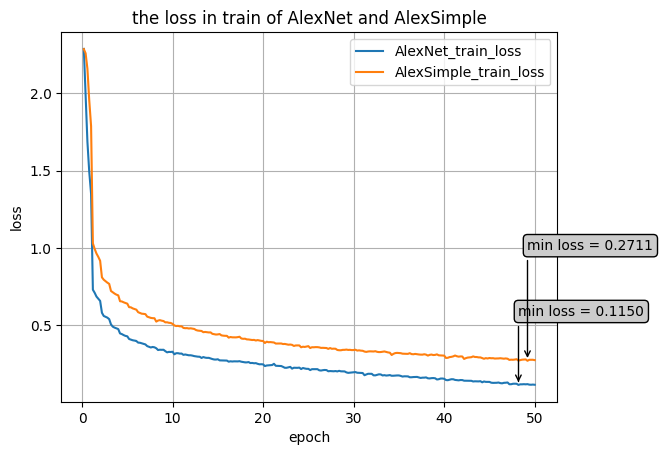

In [7]:
draw_figures(pth = os.path.join(pth, 'ch7_01.csv'),
             label_list=[('AlexNet_epoch_train', 'AlexNet_train_loss'), 
                        ('AlexSimple_epoch_train', 'AlexSimple_train_loss')],
             title='the loss in train of AlexNet and AlexSimple')

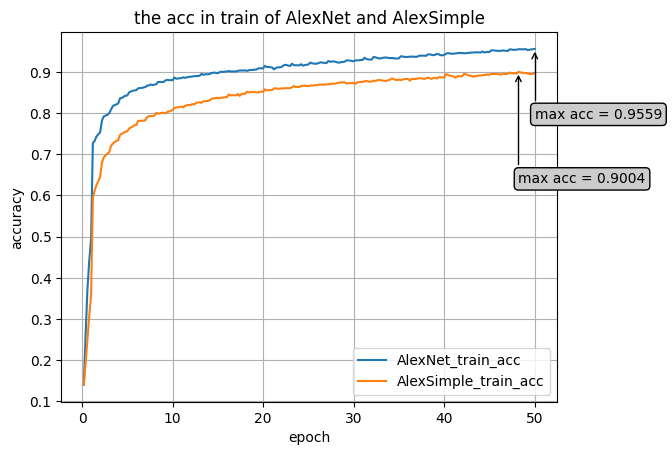

In [8]:
draw_figures(pth = os.path.join(pth, 'ch7_01.csv'),
             label_list=[('AlexNet_epoch_train', 'AlexNet_train_acc'), 
                         ('AlexSimple_epoch_train', 'AlexSimple_train_acc')],
             title='the acc in train of AlexNet and AlexSimple')

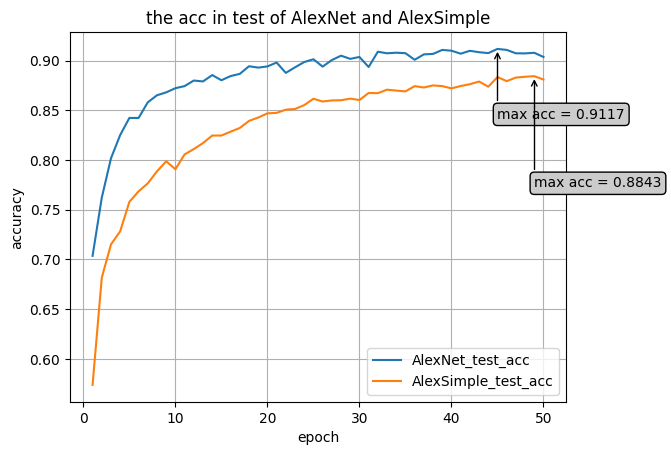

In [9]:
draw_figures(pth = os.path.join(pth, 'ch7_01_eval.csv'),
             label_list=[('AlexNet_epoch_test', 'AlexNet_test_acc'), 
                         ('AlexSimple_epoch_test', 'AlexSimple_test_acc')],
             title='the acc in test of AlexNet and AlexSimple')

&emsp;&emsp;简化后的设计相比原有网络在准确率上下降了3个百分点左右，但网络的运行效率大大增加，运行时间较原网络提升了约40%左右，基本保持了原有的精度。

### 练习 7.1.3

修改批量大小，并观察模型精度和GPU显存变化。

**解答：**

&emsp;&emsp;分别对比`batch_size`为64、128、512时的模型精度和GPU显存变化。

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np

AlexNet = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

&emsp;&emsp;batch_size=64，显存占用为：3.74GB，模型精度：loss 0.274, train acc 0.898, test acc 0.895

loss 0.274, train acc 0.898, test acc 0.895
1340.3 examples/sec on cuda:0


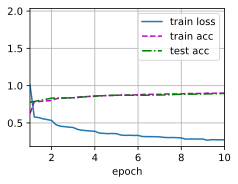

In [ ]:
batch_size = 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
lr, num_epochs = 0.01, 10
d2l.train_ch6(AlexNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;batch_size=128，显存占用为：7.93GB，模型精度：loss 0.324, train acc 0.880, test acc 0.886

loss 0.324, train acc 0.880, test acc 0.886
1627.7 examples/sec on cuda:0


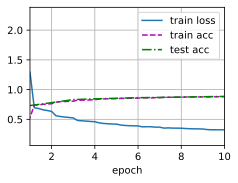

In [ ]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
lr, num_epochs = 0.01, 10
d2l.train_ch6(AlexNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;batch_size=512，显存占用为：7.93GB，模型精度：loss 0.504, train acc 0.811, test acc 0.823

loss 0.504, train acc 0.811, test acc 0.823
1439.9 examples/sec on cuda:0


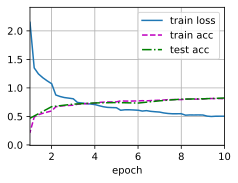

In [ ]:
batch_size = 512
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
lr, num_epochs = 0.01, 10
d2l.train_ch6(AlexNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;在上面的实验中可以看出，batch_size越大运行所需要的显存就越多，模型的精度也会降低。

&emsp;&emsp;在一定范围内，增加batchsize有助于收敛的稳定性，但是随着batchsize的增加，模型的性能会下降。

&emsp;&emsp;较小的batch_size通常可以提供更好的泛化能力，因为它引入了一定的噪声，有助于模型避免陷入局部最优解。但其缺点是由于噪声较大，训练过程可能不够稳定，需要更多的迭代次数才能收敛。

&emsp;&emsp;较大的batch_size可以减少模型更新的次数，有助于训练过程的稳定性。同样其也存在一定的缺点：大批量可能会降低模型的泛化能力，因为它减少了噪声的引入，有时可能导致模型过早陷入局部最优。

&emsp;&emsp;通常batch_size越大，一次迭代中处理的数据量就越大，因此需要更多的内存或显存来存储这些数据及其梯度。对于有限的硬件资源，这可能成为限制因素。



### 练习 7.1.4

分析AlexNet的计算性能。
1. 在AlexNet中主要是哪部分占用显存？
1. 在AlexNet中主要是哪部分需要更多的计算？
1. 计算结果时显存带宽如何？

**解答：**

我们首先使用`torchinfo`中的`summary()`函数观察医学AlexNet的网络结构

In [48]:
import torchinfo
AlexNet= models.AlexNet()
torchinfo.summary(AlexNet, (1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 96, 54, 54]           11,712
│    └─ReLU: 2-2                         [1, 96, 54, 54]           --
│    └─MaxPool2d: 2-3                    [1, 96, 26, 26]           --
│    └─Conv2d: 2-4                       [1, 256, 26, 26]          614,656
│    └─ReLU: 2-5                         [1, 256, 26, 26]          --
│    └─MaxPool2d: 2-6                    [1, 256, 12, 12]          --
│    └─Conv2d: 2-7                       [1, 384, 12, 12]          885,120
│    └─ReLU: 2-8                         [1, 384, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 384, 12, 12]          1,327,488
│    └─ReLU: 2-10                        [1, 384, 12, 12]          --
│    └─Conv2d: 2-11                      [1, 256, 12, 12]       

**问题1**

&emsp;&emsp;首先，对于训练过程的显存占用，主要分为两部分，一部分为网络参数占用显存，另一部分为在传播过程中模型所占用显存。

&emsp;&emsp;对于网络参数占据显存：在AlexNet中，网络参数占据最多显存的层是是我们后面的**全连接层**，在AlexNet中，网络参数的显存主要被以下两部分占用（relu等没有参数的层相比之下的显存占据量可以忽略）：

* 卷积层（Convolutional Layers）：这些层主要储存权重（卷积核）和特征图（feature maps）。每个卷积层包含多个卷积核，每个核都有自己的权重参数，而特征图则是每层的输出。由于卷积层通常使用更多的卷积核和较大的特征图，因此它们往往占据较多显存。
  $$
  \text{Memory} =  \text{ Number ~ of ~ Filters} \times (\text{Filter~ Size} \times \text{Input~ Channels} + 1) \times 4 \text{bytes}
  $$

* 全连接层（Fully Connected Layers）：这些层储存连接网络各层的权重。
  $$
  \text{Memory}=   \text{Number~of~Input} \times (\text{Number~of~Output} + 1) \times 4 \text{bytes} 
  $$
&emsp;&emsp;乘4 bytes（此处默认每个网络参数都是`float32`的类型）之前，其得到的值也就是该层参数的值，这也是与上面的`summary()`对应的.

&emsp;&emsp;对于模型占据显存：我们可以这么来看，不论是前向传播还是反向传播过程，输入每经过一层网络（不论是`Conv2d` `linear` `dropout`），都会缓存下经过这一次网络的输出。

&emsp;&emsp;以AlexNet为例，训练过程如下：
1. 首先对于`(1, 1, 224, 224)`的输入，其内存占用为$1\times1\times224\times224\times4\text{byte}=0.191$，就是这里的`Input size (MB): 0.20`；
2. 经过第一层`Conv2d`后输出`(1, 96, 54, 54)`，其内存占用为$1\times96\times54\times54\times4\text{byte}$；
3. 经过非参数层`ReLu`后输出`(1, 96, 54, 54)`，其内存占用为$1\times96\times54\times54\times4\text{byte}$。
4. 以此类推，可以得到整个网络模型大小约为`summary()`中的`Forward/backward pass size (MB): 4.87`

&emsp;&emsp;那么对于整个训练过程的内存占用，我们可以这么计算：

&emsp;&emsp;在训练过程中，以AlexNet使用`SGD`化器并结合`momentum`算法，`batch_size=128`
* 参数显存`Params size (MB): 187.06`，总训练过程占用为$187.06\times3$（`SGD`和`momentum`各需要一份参数）
* 模型显存为$~4.87\times128\times2 ~\text{MB}$，(乘2是因为有**前向和反向**两个过程)
* 两者之和则是网络占用显存总量


**问题2**

&emsp;&emsp;在这个模型中，需要更多计算的层主要是全连接层。全连接层的计算量与输入和输出的维度相关，因此输入维度为6400的第一层全连接层和输出维度为4096的第二层全连接层需要更多的计算。这两个全连接层的计算量是其他卷积层的数倍，也是整个模型计算量的瓶颈。因此，在实际应用中，可以考虑减少全连接层的数量和神经元个数，以减少计算量并提高模型的运行速度。
* 卷积层运算：
$$
\text{Total ~ Cost}=\text{Number ~ of ~ Filters}\times \text{Filter ~ Size}\times \text{Input ~ Channels}\times \text{Output ~ Height}\times \text{Output ~ Width}
$$
* 全连接层运算：
$$
\text{Total ~ Cost}=\text{Input ~ Neurons}\times \text{Output ~ Neurons}
$$

**问题3**

&emsp;&emsp;此问题，在英文原版教材中的提问为：
>How does the memory (read and write bandwidth, latency, size) affect computation? Is there any difference in its effects for training and inference?

&emsp;&emsp;我们以此问题给出答案：
1. 读写带宽

&emsp;&emsp;训练阶段：在训练期间，高带宽是至关重要的，因为它允许GPU和内存之间更快的数据传输。在处理大型数据集和执行批处理时，这一点尤其重要。高带宽确保GPU快速接收数据，减少空闲时间，加快整体训练过程。

&emsp;&emsp;推断阶段：虽然高带宽在推断阶段也有好处，但其影响通常不如训练阶段明显。这是因为推理通常涉及一次处理一个输入(与训练中的批量处理相反)，并且每个实例的数据大小更小。

2. 延迟

&emsp;&emsp;训练阶段：低延迟可以显著提高训练速度。在训练过程中，需要频繁地访问和更新数据和梯度。高延迟会减慢这些操作，导致更长的训练时间。

&emsp;&emsp;推理阶段：延迟在推理期间也很重要（但仿佛没那么重要），因为它会影响网络的响应时间。

3. 内存大小

&emsp;&emsp;训练阶段：更大的内存大小有利于训练，因为它允许更大的批处理大小，这可以提高训练过程的效率和稳定性。此外，更大的内存可以容纳更复杂的模型或具有更大输入数据大小的模型。

&emsp;&emsp;推理阶段：在推理阶段，内存大小没有训练阶段那么重要，但它仍然很重要，特别是在部署大型模型时。在内存有限的场景中(比如在移动设备上)，可能需要更小的模型或模型压缩技术。

### 练习 7.1.5

将dropout和ReLU应用于LeNet-5，效果有提升吗？再试试预处理会怎么样？

**解答：**

&emsp;&emsp;改进后的LeNet结构如下，我们定义为LeNetPro，我们在原有基础上，在每个卷积层后添加了`ReLU()`，并且在全连接层我们加入了`Dropout()`
```python
class LeNetPro(nn.Module):
    def __init__(self, in_channels=1, num_classes=10) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.net = nn.Sequential(nn.Conv2d(self.in_channels, 6, kernel_size=5, padding=2),
                                 nn.ReLU(),
                                 nn.AvgPool2d(kernel_size=2, stride=2),
                                 nn.Conv2d(6, 16, kernel_size=5), 
                                 nn.ReLU(),
                                 nn.AvgPool2d(kernel_size=2, stride=2),
                                 nn.Flatten(),
                                 nn.Linear(16 * 5 * 5, 120), 
                                 nn.ReLU(),
                                #  添加Dropout
                                 nn.Dropout(p=0.5),
                                 nn.Linear(120, 84),
                                 nn.ReLU(),  
                                #  添加Dropout
                                 nn.Dropout(p=0.5),
                                 nn.Linear(84, self.num_classes))
    def forward(self, x):
        return self.net(x)
```

&emsp;&emsp;加入`Dropout()`和`ReLU()`，并调节超参数，来对比LeNet以及LeNetPro的性能，这里我们调整学习率均为0.1以进行对比。

In [ ]:
LeNet = models.LeNet()
train_loader, test_loader = load_data_fashion_mnist(batch_size=128)
# 保持学习率统一，均为lr = 0.1
train_models(LeNet, train_loader, test_loader, epochs=50, lr=0.1, net_type='LeNet_0.1_')

LeNetPro = models.LeNetPro()
train_loader, test_loader = load_data_fashion_mnist(batch_size=128)
train_models(LeNetPro, train_loader, test_loader, epochs=50, lr=0.1, net_type='LeNetPro')

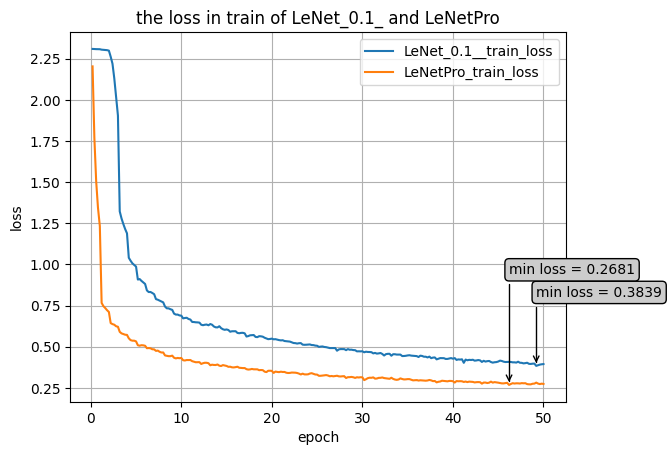

In [6]:
draw_figures(pth = os.path.join(pth, 'ch7_01.csv'),
             label_list=[('LeNet_0.1__epoch_train', 'LeNet_0.1__train_loss'), 
                         ('LeNetPro_epoch_train', 'LeNetPro_train_loss')],
             title='the loss in train of LeNet_0.1_ and LeNetPro')

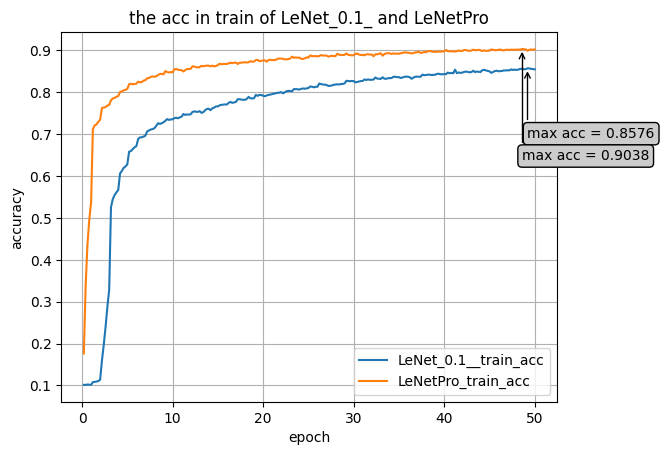

In [7]:
draw_figures(pth = os.path.join(pth, 'ch7_01.csv'),
             label_list=[('LeNet_0.1__epoch_train', 'LeNet_0.1__train_acc'), 
                         ('LeNetPro_epoch_train', 'LeNetPro_train_acc')],
             title='the acc in train of LeNet_0.1_ and LeNetPro')

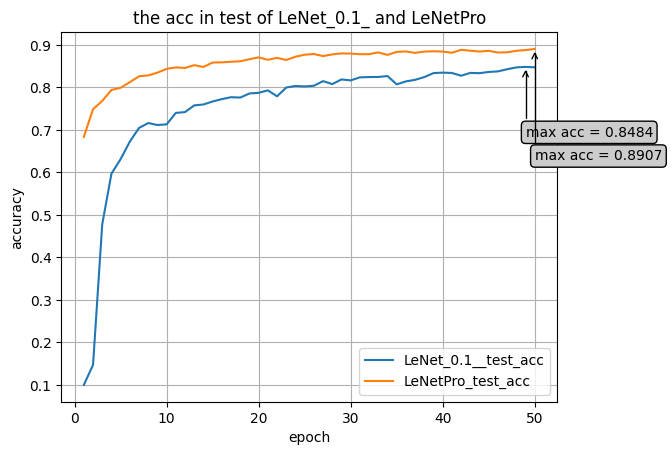

In [8]:
draw_figures(pth = os.path.join(pth, 'ch7_01_eval.csv'),
             label_list=[('LeNet_0.1__epoch_test', 'LeNet_0.1__test_acc'), 
                         ('LeNetPro_epoch_test', 'LeNetPro_test_acc')],
             title='the acc in test of LeNet_0.1_ and LeNetPro')

&emsp;&emsp;将`Dropout`和`ReLU`应用于`LeNet`之后会提升其性能：

- `Dropout`可以防止过拟合，避免神经元之间的过度共适应，从而提高网络的泛化能力。可以看出在加入`Dropout`之后，`test_acc`相比原版网络有所提升，说明网络的泛化能力得到了提高。 `Dropout`作为一种正则化技术，它在训练过程中随机地“丢弃”（即将输出置为零）神经元的一部分。这有助于模型学会不依赖于任何单个神经元，从而减少对特定训练数据的过拟合，同时通过引入噪声（即丢弃神经元），`Dropout`迫使网络在更宽泛的数据表示上进行学习，从而增强模型的泛化能力。

- `ReLU`可以增加网络的非线性，从而提高其表示能力。用`ReLU`替代`Sigmoid`之后，需要把模型的学习率调低，模型可以更加快速的收敛。

## 7.2 使用块的网络（VGG）

### 练习 7.2.1

打印层的尺寸时，我们只看到8个结果，而不是11个结果。剩余的3层信息去哪了？

**解答：**

&emsp;&emsp;我们直接打印模型，模型的定义与打印函数封装在`models.py`当中。

In [9]:
import torch
from torch import nn
from d2l import torch as d2l
import models

vgg11 = models.vgg11()
vgg11.print_layers()

In Sequential:
Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 64, 112, 112])
-------------------
In Sequential:
Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 128, 56, 56])
-------------------
In Sequential:
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
MaxPool2d output shape:	 torch.Size([1, 256, 28, 28])
-------------------
In Sequential:
Conv2d output shape:	 torch.Size([1, 512, 28, 28])
ReLU output shape:	 torch.Size([1, 512, 28, 28])
Conv2d output shape:	 torch.Size([1, 512, 28, 28])
ReLU output shape:	 torch.Size([1, 512, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 512, 14, 14])
-------------------
In Sequential:
Conv2d output shape:	 

&emsp;&emsp;这里的输出是13行，但是本质上输出的是8层神经网络。其中`Sequential`5层，其中`Linear`3层，`ReLU`，`Dropout`这些层都不算的，因为它们不是神经元。

&emsp;&emsp;原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。

&emsp;&emsp;我们可以得知前两个`Sequential`层包含了1个卷积层，后三个`Sequential`层包含了两个卷积层。

### 练习 7.2.2

与AlexNet相比，VGG的计算要慢得多，而且它还需要更多的显存。分析出现这种情况的原因。

**解答：**

&emsp;&emsp;使用`torchinfo`打印网络结构

In [3]:
import models
import torchinfo

vgg11 = models.vgg11()
torchinfo.summary(vgg11, (1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Sequential: 2-1                   [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         640
│    │    └─ReLU: 3-2                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-3               [1, 64, 112, 112]         --
│    └─Sequential: 2-2                   [1, 128, 56, 56]          --
│    │    └─Conv2d: 3-4                  [1, 128, 112, 112]        73,856
│    │    └─ReLU: 3-5                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [1, 128, 56, 56]          --
│    └─Sequential: 2-3                   [1, 256, 28, 28]          --
│    │    └─Conv2d: 3-7                  [1, 256, 56, 56]          295,168
│    │    └─ReLU: 3-8                    [1, 256, 56, 56]          --
│    

&emsp;&emsp;结合在习题7.1.4中的回答分析，其原因可以有以下两点：

&emsp;&emsp;1. 更深的网络结构：VGG相比于AlexNet增加了网络层数，采用了16-19层的卷积层，这导致了计算量的增加和运行过程中模型占用显存的增加（这是最主要原因）。

&emsp;&emsp;2. 更小的卷积核：VGG网络中采用了较小的3x3卷积核，相比AlexNet的7x7卷积核，这样做的好处是可以增加网络的深度，但是却会导致计算量和显存的需求增加。因为采用了小卷积核，需要进行更多的卷积操作，这增加了网络的参数量；同时，每个卷积核的参数数量更多，需要更多的显存进行存储，增加了显存需求。 



### 练习 7.2.3

尝试将Fashion-MNIST数据集图像的高度和宽度从224改为96。这对实验有什么影响？


**解答：**

&emsp;&emsp;由于VGG-11比AlexNet计算量更大，为保证能够正常运行，因此我们在原有VGG11的基础上，构建的一个通道数较少的网络（宽度较小），足够用于训练`fashion-mnist`数据集。

&emsp;&emsp;先加载必要的函数功能模块。

In [1]:
import torch
from torch import nn
from utlis import *
import models
import matplotlib.pyplot as plt
import pandas as pd
import os


pth = '../data/ch07_output/'
def train_models(net, 
                 train_loader, 
                 test_loader, 
                 epochs, 
                 lr, 
                 net_type : str =  None,
                 device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    # 设置优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 设置损失函数
    loss = nn.CrossEntropyLoss()
    # 初始化参数
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    
    epoch_list = []
    train_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(epochs):
    # 训练
        loss_sum = 0
        acc = 0
        net.train()
        for idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predict = net(x)
            l = loss(predict, y)
            l.backward()
            optimizer.step()
            
            loss_sum += l.item() * x.size(0)
            acc += predict.max(dim=1)[1].eq(y).sum().item()
            if (idx + 1) % (len(train_loader) // 5) == 0 or idx == len(train_loader) - 1:
                if (idx + 1) != len(train_loader):
                    loss_now = loss_sum / (idx + 1) / x.size(0)
                    acc_now = acc / (idx + 1) / x.size(0)
                else:
                    loss_now = loss_sum / len(train_loader.dataset)
                    acc_now = acc / len(train_loader.dataset)                
                train_acc.append(acc_now)
                train_loss.append(loss_now)
                epoch_list.append(epoch + (idx + 1) / len(train_loader))         
            
        # 测试
        loss_sum = 0
        acc = 0
        net.eval()
        with torch.no_grad():
            for idx, (x, y) in enumerate(test_loader):
                x, y = x.to(device), y.to(device)
                predict = net(x)
                l = loss(predict, y)
                
                acc += predict.max(dim=1)[1].eq(y).sum().item()
                
            acc /= len(test_loader.dataset)
            test_acc.append(acc)    
    epoch_test = list(range(1, int(epoch_list[-1]) + 1, 1))
    
    if net_type is not None:
        pth_csv1 = os.path.join(pth, 'ch7_02.csv')
        pth_csv2 = os.path.join(pth, 'ch7_02_eval.csv') 
    
        write2csv(pth_csv1, epoch_list, net_type + '_epoch_train')
        write2csv(pth_csv1, train_loss, net_type + '_train_loss')
        write2csv(pth_csv1, train_acc, net_type + '_train_acc')
        write2csv(pth_csv2, epoch_test, net_type + '_epoch_test')
        write2csv(pth_csv2, test_acc, net_type + '_test_acc')
    else:
        print('net_type is None, don\'t record the data')

&emsp;&emsp;训练过程如下：
<!--  -->
(考虑到训练过程过于冗长，对`vgg11`添加了相应的折扣因子，使其训练过程相对快一些)

In [ ]:
# 添加折扣因子，使vgg11的宽度（输出通道数）变为原有的1/4
Vgg11 = models.vgg11(coef=4, input_size=224)
train_loader, test_loader = load_data_fashion_mnist(batch_size=64, resize=224)

train_models(Vgg11, train_loader, test_loader, epochs=20, lr=0.05, net_type='Vgg11_224')

In [ ]:
train_loader, test_loader = load_data_fashion_mnist(batch_size=64, resize=96)
Vgg11 = models.vgg11(coef=4, input_size=96)
train_models(Vgg11, train_loader, test_loader, epochs=20, lr=0.05, net_type='Vgg11_96')

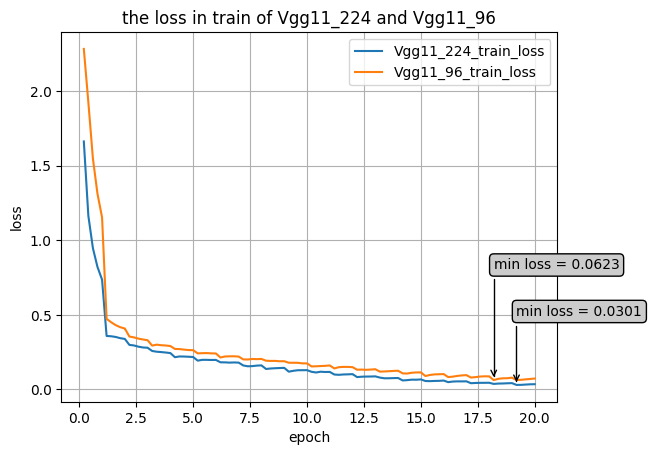

In [10]:
draw_figures(pth = os.path.join(pth, 'ch7_02.csv'),
             label_list=[('Vgg11_224_epoch_train', 'Vgg11_224_train_loss'), 
                         ('Vgg11_96_epoch_train', 'Vgg11_96_train_loss')],
             title='the loss in train of Vgg11_224 and Vgg11_96')

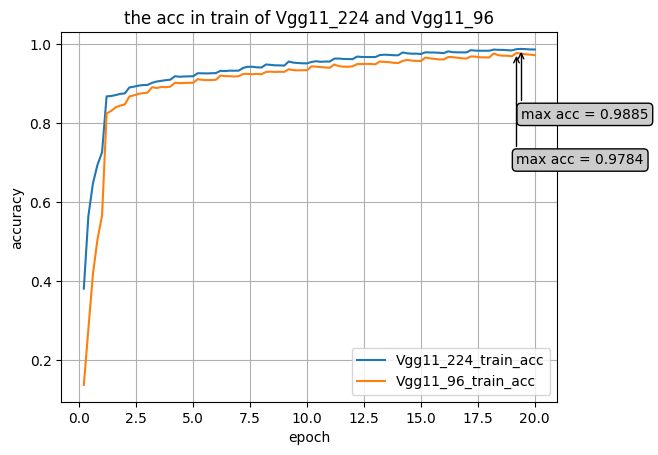

In [11]:
draw_figures(pth = os.path.join(pth, 'ch7_02.csv'),
             label_list=[('Vgg11_224_epoch_train', 'Vgg11_224_train_acc'), 
                         ('Vgg11_96_epoch_train', 'Vgg11_96_train_acc')],
             title='the acc in train of Vgg11_224 and Vgg11_96')

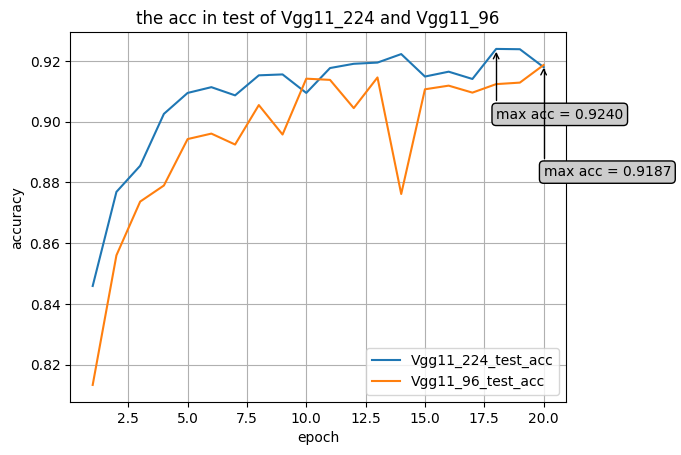

In [12]:
draw_figures(pth = os.path.join(pth, 'ch7_02_eval.csv'),
             label_list=[('Vgg11_224_epoch_test', 'Vgg11_224_test_acc'), 
                         ('Vgg11_96_epoch_test', 'Vgg11_96_test_acc')],
             title='the acc in test of Vgg11_224 and Vgg11_96')

1. 准确率下降：由于VGG网络是在ImageNet数据集上进行训练的，其输入图像大小为224 * 224。将输入图像大小从224 * 224改为96 * 96，会导致图像信息的丢失，从而影响网络的准确率。

2. 训练时间缩短：由于输入图像大小变小，计算量也相应减小，这会使得模型的训练时间缩短。

3. 内存占用减少：由于输入图像大小变小，模型参数数量也会减少，这将使得模型所需要的内存占用减少。

&emsp;&emsp;综上所述，将Fashion-MNIST数据集图像的高度和宽度从224改为96，可能会导致模型准确率下降，但同时也会缩短训练时间，减少内存占用。因此，需要根据具体的应用场景和需求来选择合适的输入图像大小。



### 练习 7.2.4

请参考VGG论文中的表1构建其他常见模型，如VGG-16或VGG-19。

**解答：**

&emsp;&emsp;参考文献：https://arxiv.org/pdf/1409.1556.pdf, 各个VGG模型的网络结构表示如下：

<img src = ..\..\images\ch07_1_2_vgg.png style="zoom:50%" title="VGG网络结构">


以下为`VGG-16`模型和`VGG-19`模型。

In [11]:
import torch
from torch import nn
from d2l import torch as d2l
import models

print("----------Vgg16 models-----------")
Vgg16 = models.vgg16()
Vgg16.print_layers()


----------Vgg16 models-----------
In Sequential:
Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 64, 112, 112])
-------------------
In Sequential:
Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 128, 56, 56])
-------------------
In Sequential:
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
MaxPool2d output shape:	 torch.Size([1, 256, 28, 28])
------

In [12]:
print("----------Vgg19 models-----------")
Vgg19 = models.vgg19()
Vgg19.print_layers()

----------Vgg19 models-----------
In Sequential:
Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 64, 112, 112])
-------------------
In Sequential:
Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 128, 56, 56])
-------------------
In Sequential:
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU outp

&emsp;&emsp;实际上，不论是VGG11、VGG13、VGG16、VGG19，其中的`vgg_block`结构块构成都是一致的，不同点在于块中的层数，因此在VGG19中，我们可以直接给出模型结构`((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))`，就可以直接构建VGG19.

## 7.3 网络中的网络（NiN）

&emsp;&emsp;NiN网络构构建如下：
```python
class NiN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10) -> None:
        super().__init__()
        
        self.in_channels = in_channels
        self.num_classes = num_classes
        # 网络结构：由四个nin_block块构成
        self.net = nn.Sequential(
            self._nin_block(self.in_channels, 96, kernel_size=11, stride=4, padding=0),
            nn.MaxPool2d(kernel_size=3, stride=2),
            self._nin_block(96, 256, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            self._nin_block(256, 384, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),
            self._nin_block(384, self.num_classes, kernel_size=3, stride=1, padding=1),
            # 将四维的输出转成二维的输出，其形状为(批量大小,标签类别)
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
    
    # nin_block块: 一层正常卷积层，两层1x1卷积层（可以看成二维全连接层）
    def _nin_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)
```

### 练习 7.3.1

调整NiN的超参数，以提高分类准确性。

**解答：**

&emsp;&emsp;首先先加载相应的包以及训练函数

In [2]:
import torch
from torch import nn
from utlis import *
import models
import matplotlib.pyplot as plt
import pandas as pd
import os

pth = '../data/ch07_output/'
def train_models(net, 
                 train_loader, 
                 test_loader, 
                 epochs, 
                 lr, 
                 net_type : str =  None,
                 device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    # 设置优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 设置损失函数
    loss = nn.CrossEntropyLoss()
    # 初始化参数
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    
    epoch_list = []
    train_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(epochs):
    # 训练
        loss_sum = 0
        acc = 0
        net.train()
        for idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predict = net(x)
            l = loss(predict, y)
            l.backward()
            optimizer.step()
            
            loss_sum += l.item() * x.size(0)
            acc += predict.max(dim=1)[1].eq(y).sum().item()
            if (idx + 1) % (len(train_loader) // 5) == 0 or idx == len(train_loader) - 1:
                if (idx + 1) != len(train_loader):
                    loss_now = loss_sum / (idx + 1) / x.size(0)
                    acc_now = acc / (idx + 1) / x.size(0)
                else:
                    loss_now = loss_sum / len(train_loader.dataset)
                    acc_now = acc / len(train_loader.dataset)                
                train_acc.append(acc_now)
                train_loss.append(loss_now)
                epoch_list.append(epoch + (idx + 1) / len(train_loader))         
            
        # 测试
        loss_sum = 0
        acc = 0
        net.eval()
        with torch.no_grad():
            for idx, (x, y) in enumerate(test_loader):
                x, y = x.to(device), y.to(device)
                predict = net(x)
                l = loss(predict, y)
                
                acc += predict.max(dim=1)[1].eq(y).sum().item()
                
            acc /= len(test_loader.dataset)
            test_acc.append(acc)    
    epoch_test = list(range(1, int(epoch_list[-1]) + 1, 1))
    
    print('the max acc in test is:', max(test_acc), 'the epoch is:', epoch_test[test_acc.index(max(test_acc))] )
    
    if net_type is not None: 
        pth_csv1 = os.path.join(pth, 'ch7_03.csv')
        pth_csv2 = os.path.join(pth, 'ch7_03_eval.csv')
        write2csv(pth_csv1, epoch_list, net_type + '_epoch_train')
        write2csv(pth_csv1, train_loss, net_type + '_train_loss')
        write2csv(pth_csv1, train_acc, net_type + '_train_acc')
        write2csv(pth_csv2, epoch_test, net_type + '_epoch_test')
        write2csv(pth_csv2, test_acc, net_type + '_test_acc')
    else:
        print('net_type is None, don\'t record the data')

&emsp;&emsp;对于模型的超参数，我们主要有两个参数可以选择，第一个是学习率$\text{lr}$，第二个是训练批次$\text{Batch ~ Size}$，我们选择以下五组颇具代表性的参数列表，来简单探索学习率与训练批次对模型预测效果的影响

In [2]:
hyper_0 = [0.1, 30, 128]
hyper_1 = [0.08, 30, 128]
hyper_2 = [0.1, 30, 64]
hyper_3 = [0.1, 30, 512]
hyper_4 = [0.2, 30, 128]
hyper_params = [hyper_0, hyper_1, hyper_2, hyper_3, hyper_4]


In [3]:
for hyper in hyper_params:
    lr, num_epochs, batch_size = hyper[0], hyper[1], hyper[2]
    train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size, resize=96)
    net = models.NiN()
    print(f"lr: {hyper[0]}, num_epochs: {hyper[1]}, batch_size: {hyper[2]}")
    train_models(net, train_loader, test_loader, num_epochs, lr, 'Nin'+str(hyper[0])+'_'+str(hyper[2]))


lr: 0.1, num_epochs: 30, batch_size: 128
the max acc in test is: 0.8186 the epoch is: 29
lr: 0.08, num_epochs: 30, batch_size: 128
the max acc in test is: 0.8207 the epoch is: 27
lr: 0.1, num_epochs: 30, batch_size: 64
the max acc in test is: 0.8236 the epoch is: 25
lr: 0.1, num_epochs: 30, batch_size: 512
the max acc in test is: 0.761 the epoch is: 30
lr: 0.2, num_epochs: 30, batch_size: 128
the max acc in test is: 0.4854 the epoch is: 30


&emsp;&emsp;绘制图像来观察不同参数对训练过程的影响：

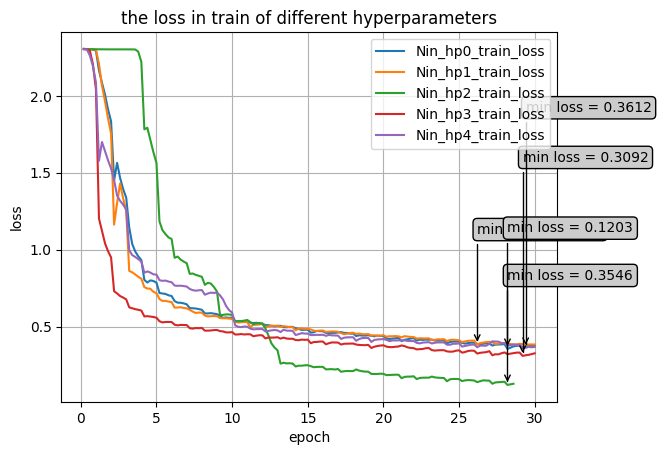

In [14]:
draw_figures(os.path.join(pth, 'ch7_03.csv'),
             [('Nin_hp0_epoch_train', 'Nin_hp0_train_loss'),
              ('Nin_hp1_epoch_train', 'Nin_hp1_train_loss'), 
              ('Nin_hp2_epoch_train', 'Nin_hp2_train_loss'), 
              ('Nin_hp3_epoch_train', 'Nin_hp3_train_loss'), 
              ('Nin_hp4_epoch_train', 'Nin_hp4_train_loss')],
             title='the loss in train of different hyperparameters')

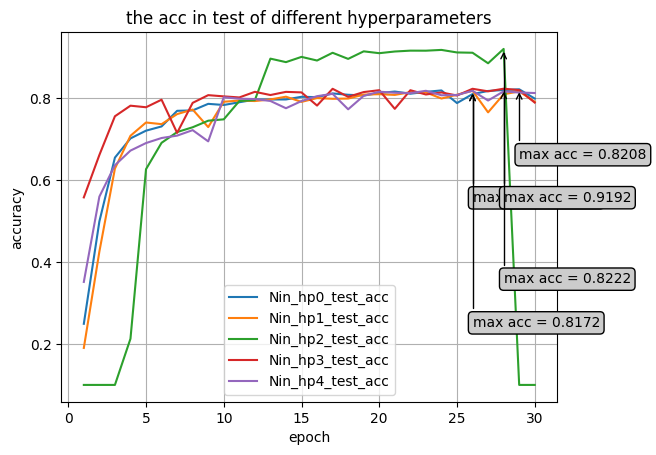

In [15]:
draw_figures(os.path.join(pth, 'ch7_03_eval.csv'),
             [('Nin_hp0_epoch_test', 'Nin_hp0_test_acc'),
              ('Nin_hp1_epoch_test', 'Nin_hp1_test_acc'), 
              ('Nin_hp2_epoch_test', 'Nin_hp2_test_acc'), 
              ('Nin_hp3_epoch_test', 'Nin_hp3_test_acc'), 
              ('Nin_hp4_epoch_test', 'Nin_hp4_test_acc')],
             title='the acc in test of different hyperparameters')

&emsp;&emsp;可以看出在这组`lr: 0.1, num_epochs: 10, batch_size: 64`参数下模型的精度最高。

&emsp;&emsp;也可以看到，在`lr: 0.1, num_epochs: 10, batch_size: 64`训练到最后，其梯度突然发生了爆炸（消失），导致准确率陡降。实际上在训练NiN模型的时候，经常会遇到梯度爆炸、消失，或者模型不收敛的情况。

### 练习 7.3.2

为什么NiN块中有两个$1\times 1$卷积层？删除其中一个，然后观察和分析实验现象。

**解答：**

&emsp;&emsp;从主观上来看，删除一层$1\times 1$卷积层，NiN块的效果肯定会下降，因为作为提供网络对空间特征的抽象能力，作为原来全连接层替代的$1\times 1$卷积层，理应提供更深层次的特征抽象能力，但结果真的如我们直觉所想的这样吗，我们可以观察以下实验结果：

&emsp;&emsp;主要考虑输入图像大小对性能的影响，我们进行以下一系列实验：

&emsp;&emsp;使用简化的NiN模块，对比不同输入下的模型表现：

In [15]:
lr, num_epochs, batch_size = 0.1, 30, 64

for val in [96, 168, 224]:
    
    NiN_simple = models.NiN_Simple()
    resize = val
    train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size, resize=resize)
    train_models(NiN_simple, train_loader, test_loader, num_epochs, lr, 'Nin_simple_minst'+str(resize))


the max acc in test is: 0.9207 the epoch is: 20
the max acc in test is: 0.4598 the epoch is: 28
the max acc in test is: 0.9185 the epoch is: 29


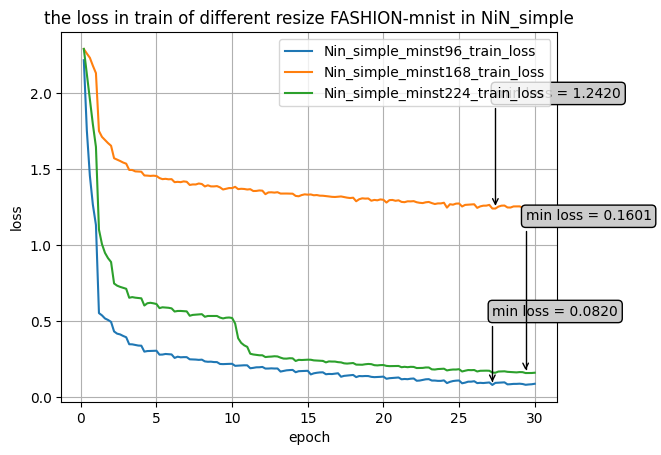

In [17]:
draw_figures(os.path.join(pth, 'ch7_03.csv'),
             [('Nin_simple_minst96_epoch_train', 'Nin_simple_minst96_train_loss'),
              ('Nin_simple_minst168_epoch_train', 'Nin_simple_minst168_train_loss'), 
              ('Nin_simple_minst224_epoch_train', 'Nin_simple_minst224_train_loss')],
             title='the loss in train of different resize FASHION-mnist in NiN_simple')

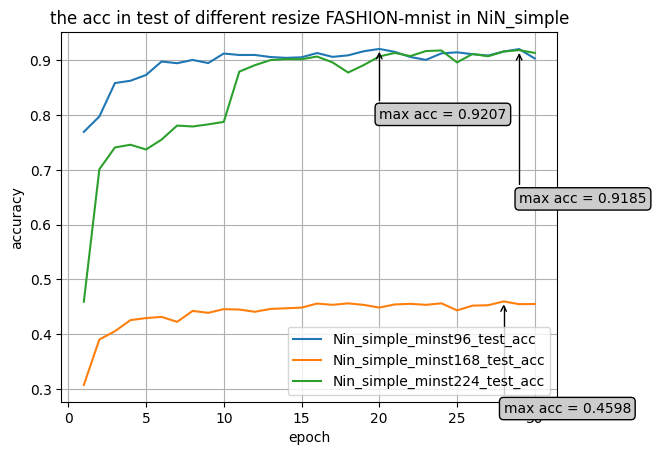

In [18]:
draw_figures(os.path.join(pth, 'ch7_03_eval.csv'),
             [('Nin_simple_minst96_epoch_test', 'Nin_simple_minst96_test_acc'),
             ('Nin_simple_minst168_epoch_test', 'Nin_simple_minst168_test_acc'), 
             ('Nin_simple_minst224_epoch_test', 'Nin_simple_minst224_test_acc')],
             title='the acc in test of different resize FASHION-mnist in NiN_simple')

&emsp;&emsp;输入图像大小会对正确率有较显著影响。

&emsp;&emsp;对比之下，相对流行的96 * 96以及224 * 224两个图片尺寸的准确率相当，但使用168 * 168图像尺寸的时候，模型的准确率大打折扣，甚至都没有收敛。

&emsp;&emsp;下面再看使用完整NiN模型时的表现：

In [16]:
lr, num_epochs, batch_size = 0.1, 30, 64
for val in [96, 168, 224]:
    
    NiN = models.NiN()
    resize = val
    train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size, resize=resize)
    train_models(NiN, train_loader, test_loader, num_epochs, lr, 'Nin_minst'+str(resize))


the max acc in test is: 0.9167 the epoch is: 26
the max acc in test is: 0.3926 the epoch is: 1
the max acc in test is: 0.9207 the epoch is: 30


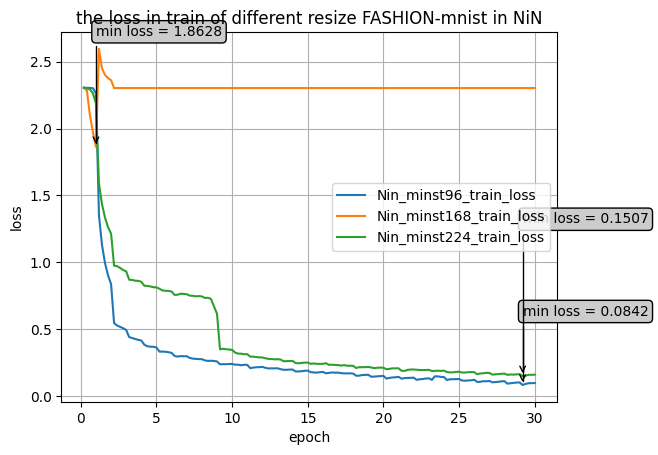

In [19]:
draw_figures(os.path.join(pth, 'ch7_03.csv'),
             [('Nin_minst96_epoch_train', 'Nin_minst96_train_loss'),
             ('Nin_minst168_epoch_train', 'Nin_minst168_train_loss'), 
             ('Nin_minst224_epoch_train', 'Nin_minst224_train_loss')],
             title='the loss in train of different resize FASHION-mnist in NiN')

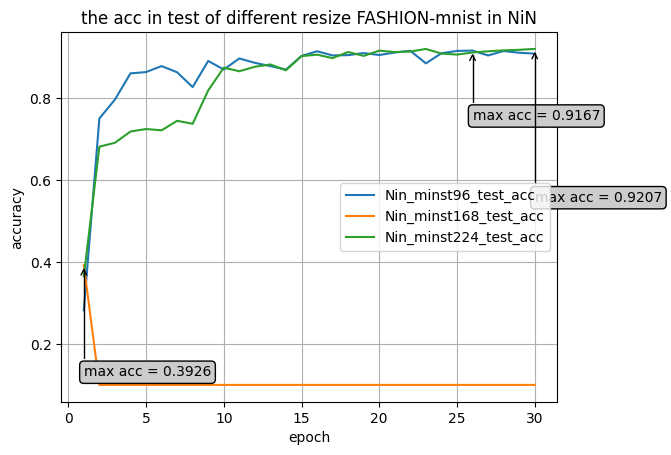

In [20]:
draw_figures(os.path.join(pth, 'ch7_03_eval.csv'),
             [('Nin_minst96_epoch_test', 'Nin_minst96_test_acc'),
             ('Nin_minst168_epoch_test', 'Nin_minst168_test_acc'), 
             ('Nin_minst224_epoch_test', 'Nin_minst224_test_acc')],
             title='the acc in test of different resize FASHION-mnist in NiN')

&emsp;&emsp;我们会发现，实际上结果出奇的相似，删除一层$1\times 1$对模型最后的效果影响并不大，甚至还对模型运行结果有一定的提高。这与我们的直观理解是相违背的。

&emsp;&emsp;我们尝试使用`CIFAR10`数据集再次运行，看此时模型的表现是否还是如此：

In [4]:
lr, num_epochs, batch_size = 0.1, 30, 64
for val in [96, 168, 224]:
    
    NiN = models.NiN(in_channels=3)
    resize = val
    train_loader, test_loader = load_data_cifar10(batch_size=batch_size, resize=resize)
    train_models(NiN, train_loader, test_loader, num_epochs, lr, 'Nin_cifar10_'+str(resize))


Files already downloaded and verified
Files already downloaded and verified
the max acc in test is: 0.7325 the epoch is: 30
Files already downloaded and verified
Files already downloaded and verified
the max acc in test is: 0.7862 the epoch is: 27
Files already downloaded and verified
Files already downloaded and verified
the max acc in test is: 0.7536 the epoch is: 27


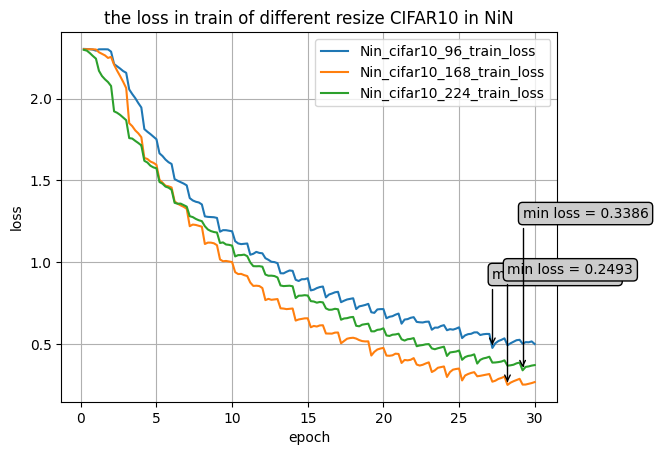

In [21]:
draw_figures(os.path.join(pth, 'ch7_03.csv'),
             [('Nin_cifar10_96_epoch_train', 'Nin_cifar10_96_train_loss'),
             ('Nin_cifar10_168_epoch_train', 'Nin_cifar10_168_train_loss'), 
             ('Nin_cifar10_224_epoch_train', 'Nin_cifar10_224_train_loss')],
             title='the loss in train of different resize CIFAR10 in NiN')

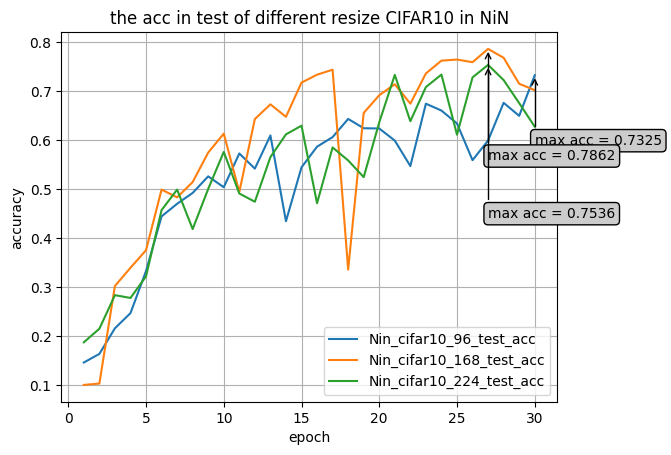

In [24]:
draw_figures(os.path.join(pth, 'ch7_03_eval.csv'),
             [('Nin_cifar10_96_epoch_test', 'Nin_cifar10_96_test_acc'),
             ('Nin_cifar10_168_epoch_test', 'Nin_cifar10_168_test_acc'), 
             ('Nin_cifar10_224_epoch_test', 'Nin_cifar10_224_test_acc')],
             title='the acc in test of different resize CIFAR10 in NiN')

In [5]:
for val in [96, 168, 224]:
    
    NiN_simple = models.NiN_Simple(in_channels=3)
    resize = val
    train_loader, test_loader = load_data_cifar10(batch_size=batch_size, resize=resize)
    train_models(NiN_simple, train_loader, test_loader, num_epochs, lr, 'Nin_simple_cifar10_'+str(resize))


Files already downloaded and verified
Files already downloaded and verified
the max acc in test is: 0.7487 the epoch is: 28
Files already downloaded and verified
Files already downloaded and verified
the max acc in test is: 0.7929 the epoch is: 26
Files already downloaded and verified
Files already downloaded and verified
the max acc in test is: 0.7982 the epoch is: 24


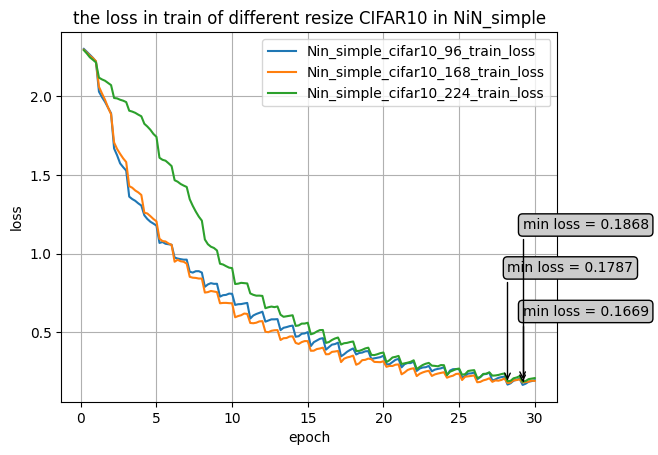

In [23]:
draw_figures(os.path.join(pth, 'ch7_03.csv'),
             [('Nin_simple_cifar10_96_epoch_train', 'Nin_simple_cifar10_96_train_loss'),
             ('Nin_simple_cifar10_168_epoch_train', 'Nin_simple_cifar10_168_train_loss'), 
             ('Nin_simple_cifar10_224_epoch_train', 'Nin_simple_cifar10_224_train_loss')],
             title='the loss in train of different resize CIFAR10 in NiN_simple')

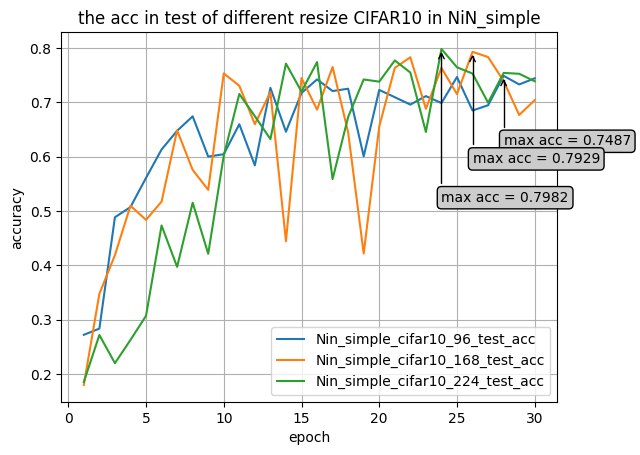

In [22]:
draw_figures(os.path.join(pth, 'ch7_03_eval.csv'),
             [('Nin_simple_cifar10_96_epoch_test', 'Nin_simple_cifar10_96_test_acc'),
             ('Nin_simple_cifar10_168_epoch_test', 'Nin_simple_cifar10_168_test_acc'), 
             ('Nin_simple_cifar10_224_epoch_test', 'Nin_simple_cifar10_224_test_acc')],
             title='the acc in test of different resize CIFAR10 in NiN_simple')

&emsp;&emsp;哪怕使用了相对复杂的`CIFAR10`数据集，`NiN`以及`NiN_simple`在表现上并无显著差异，对此我们只能猜测，可能是这两类数据集的数据像素都过少，深层信息也相对较少，因此两层$1\times1$卷积层可能会对任务产生冗余，本身`NiN`的设计便不是面向此类小规模数据集的，因此可能会出现此类情况。


&emsp;&emsp;总结一下：删除其中一个 $1 \times 1$ 卷积层，将对网络的性能产生以下可能影响：

1. **参数数量和计算量的减少**：去掉一个 $1 \times 1$ 卷积层会减少模型的参数数量，这可能导致更快的训练和推理速度，但同时也可能减少模型的学习能力，但对于简单任务，其影响可以忽略不计。

2. **特征抽象能力的下降**：从理论上来讲，两个 $1 \times 1$ 卷积层的作用是逐步抽象特征，提供更复杂的非线性变换。删除其中一个可能会降低模型捕捉复杂特征的能力，这可能导致模型性能下降，但不论在数据集`Fashion-minist`还是在数据集`CIFAR10`上，其最后的正确率上均没有太大差距，甚至两者学习率相当，这一点可能是数据集任务过于简单所造成的。

3. **过拟合风险的改变**：较少的参数意味着模型的容量减小，这可能会降低过拟合的风险，但也可能导致欠拟合，即模型无法完全学习训练数据中的特征。



### 练习 7.3.3

计算NiN的资源使用情况。
1. 参数的数量是多少？
1. 计算量是多少？
1. 训练期间需要多少显存？
1. 预测期间需要多少显存？

**解答：**

**问题1**

&emsp;&emsp;根据练习7.1.4所给出的公式，参数计算与模型内存占用计算相比，只是少了最后将参数量转化为内存占用量所乘的$4 ~bytes$.

&emsp;&emsp;对于全连接层，参数数量为输入通道数乘以输出通道数并加上输出通道数大小的偏置，计算方法：
$$
params = channel_{input} \times (channel_{output}+1)
$$

&emsp;&emsp;对于每个卷积层，参数数量为输入通道数乘以卷积核尺寸乘以输出通道数，加上输出通道数作为偏置项的数量(在此处，卷积核的个数实际上就是输出通道的个数)。
$$
params =   Number ~ of ~ Filters \times (Filter~ Size \times Input~ Channels + 1)  
$$

&emsp;&emsp;第一个`nin_block`的参数数量为$11 \times 11 \times 3 \times 96+1 \times 1 \times 96 \times 96+1 \times 1 \times 96 \times 96=53280$

&emsp;&emsp;第二个`nin_block`的参数数量为$5 \times 5 \times 96 \times 256+1 \times 1 \times 256 \times 256+1 \times 1 \times 256 \times 256=745472$

&emsp;&emsp;第三个`nin_block`的参数数量为$3 \times 3 \times 256 \times 384+1 \times 1 \times 384 \times 384+1 \times 1 \times 384 \times 384=1179648$

&emsp;&emsp;最后一个`nin_block`的参数数量为$3 \times 3 \times 384 \times 10+1 \times 1 \times 10 \times 10+1 \times 1 \times 10 \times 10=34760$

&emsp;&emsp;模型的总参数数量为$53280+745472+1179648+34760=2013160$

**问题2**

&emsp;&emsp;对于网络计算量，通常使用FLOPs（Floating Point Operations）作为衡量指标，这是是衡量计算复杂度的重要指标。对于不同类型的层，如卷积层、全连接层和其他类型的层，计算FLOPs的方式有所不同。下面是一些常见层类型的FLOP计算方法：

- **卷积层**: 对于一个卷积层，FLOP的计算公式（考虑偏置`bias`）是：
$$
\text{FLOPs} = 2 \times Output ~ Height\times Output ~ Width \times params
$$
&emsp;&emsp;这里的乘法和加法都算作一个操作，因此有一个乘以2的因子。输出高度和宽度指的是卷积操作后的特征图尺寸。

- **全连接层**: 对于一个全连接层，FLOP的计算公式（考虑`bias`）是：
$$
\text{FLOPs} = 2 \times channel_{input} \times channel_{output}
$$
&emsp;&emsp;全连接层的计算是基于矩阵乘法，因此计算量取决于输入和输出单元的数量。

- **激活层（如ReLU）**: 通常每个神经元只需要一个操作（比如一个比较或一个加法），因此FLOPs可以简单地按照输出神经元的数量计算。
- **池化层（Pooling Layer）**: 对于最大池化，FLOPs通常等于输出特征图中的元素数量。对于平均池化，可能需要计算平均值，因此FLOPs稍高。
- **Batch Normalization**: 通常需要两次操作（乘法和加法）每个输出元素，所以FLOPs等于输出元素数量的两倍。
- **Dropout**: 在测试时，dropout层不改变FLOPs，因为它只在训练时起作用。在训练时，其FLOPs可以忽略不计。

&emsp;&emsp;需要注意的是，这些计算假设了简化的操作成本，实际中可能会因为各种优化和硬件特性而有所不同。对于具体的网络架构，计算总的FLOPs通常需要将所有层的FLOPs累加起来，但是对于某些特殊层，计算其计算量较为复杂，因此很难得到网络的确切计算量。但除去卷积层和全连接层以外，其他层对于计算量的贡献占比相对较小，因此使用卷积层以及全连接层计算量的总和来**估计**网络的总计算量（实际使用时很少有人care计算量到底有多少）。


&emsp;&emsp;所以计算量等于  $ layer ~ params \times Output ~ Height\times Output ~ Width$ ，即总计算量为$53280 \times 54 \times 54+745472 \times 27 \times 27+1179648 \times 13 \times 13+34760 \times 1 \times 1=898208840≈8.9 \times 10^8$



**问题3**

&emsp;&emsp;显存里包含的内容有：参数的权重，参数的梯度，以及梯度反向传播过程中的中间值，最后还有数据（batch_size）.所以根据每个人所使用的参数不同，显卡型号不同，显存大小也会有不同。但结合7.1.4所给出的答案，我们也可以估计训练过程的显存占用。

&emsp;&emsp;显存仍是被分为两部分，一部分模型参数占用，一部分数据传递占用。

* 参数显存`Params size (MB): 7.97`，总训练过程中，假设使用`SGD`和`momentum`进行训练，这两者各需要一份参数。总占用为$7.97\times3=23.91(MB)$
* 假设输入数据为$1*224*224$，其`batch_size`为64，数据传递占用显存为$~781.11(MB)$，考虑到训练过程中有**前向和反向**两个过程，因此需要乘2，得到数据传递显存占用为$781.11times2=1562.22(MB)$.
* 两者之和则是网络占用显存总量,为$1562.22+23.91=1586.13(MB)=1.55(GB)$



In [26]:
import torchinfo
import models
NiN = models.NiN()
torchinfo.summary(NiN, (64, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
NiN                                      [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Sequential: 2-1                   [64, 96, 54, 54]          --
│    │    └─Conv2d: 3-1                  [64, 96, 54, 54]          11,712
│    │    └─ReLU: 3-2                    [64, 96, 54, 54]          --
│    │    └─Conv2d: 3-3                  [64, 96, 54, 54]          9,312
│    │    └─ReLU: 3-4                    [64, 96, 54, 54]          --
│    │    └─Conv2d: 3-5                  [64, 96, 54, 54]          9,312
│    │    └─ReLU: 3-6                    [64, 96, 54, 54]          --
│    └─MaxPool2d: 2-2                    [64, 96, 26, 26]          --
│    └─Sequential: 2-3                   [64, 256, 26, 26]         --
│    │    └─Conv2d: 3-7                  [64, 256, 26, 26]         614,656
│    │    └─ReLU: 3-8                    [64, 256, 26, 26]         --


**问题4**

&emsp;&emsp;与问题3类似，在测试过程中，数据只需要前向传播，其内存占用约为$7.97+781.11=801.93(MB)$

### 练习 7.3.4

一次性直接将$384 \times 5 \times 5$的表示缩减为$10 \times 5 \times 5$的表示，会存在哪些问题？

**解答：**

&emsp;&emsp;在最后一层中，一次性直接将$384×5×5$的表示缩减为$10×5×5$的表示，可能会导致信息丢失。
&emsp;&emsp;对比前面几层，模型先将从$96×26×26$扩展到$256×12×12$，再扩展到$384×5×5$，经过了三个`nin_block`，而在最后一层中，模型一次性直接将通道数压缩至$10×5×5$，这个过程中的参数量相比前一个信息提取过程，参数量显著减小。
这是因为在这一层中，输出通道的数量从384减少到了10，这意味着模型必须在这一层中丢弃大量的信息。这可能会影响模型的性能。

&emsp;&emsp;这种设计也有其优点。它可以减少模型所需的参数数量，从而减少过拟合的风险，并加快模型的训练速度。因此，在实际应用中，需要在保留足够信息和减少模型复杂度之间取得平衡。

## 7.4 含并行链接的网络（GoogleLeNet）

### 练习 7.4.1

GoogLeNet有一些后续版本。尝试实现并运行它们，然后观察实验结果。这些后续版本包括：
1. 添加批量规范化层 （batch normalization），（在7.5节中将介绍）；
1. 对Inception模块进行调整；
1. 使用标签平滑（label smoothing）进行模型正则化；
1. 加入残差连接（将在7.6节中介绍）。

**解答：**

&emsp;&emsp;首先同样，我们加载相应的包以及训练函数

In [28]:
import torch
from torch import nn
from utlis import *
import models
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import os

pth = '../data/ch07_output/'
def train_models(net, 
                 train_loader, 
                 test_loader, 
                 epochs, 
                 lr, 
                 net_type : str =  None,
                 loss_set = None,
                 device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    # 设置优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 设置损失函数
    if loss_set is None:
        loss = nn.CrossEntropyLoss()
    else:
        loss = loss_set
    # 初始化参数
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    
    epoch_list = []
    train_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(epochs):
    # 训练
        loss_sum = 0
        acc = 0
        net.train()
        for idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predict = net(x)
            l = loss(predict, y)
            l.backward()
            optimizer.step()
            
            loss_sum += l.item() * x.size(0)
            acc += predict.max(dim=1)[1].eq(y).sum().item()
            if (idx + 1) % (len(train_loader) // 5) == 0 or idx == len(train_loader) - 1:
                if (idx + 1) != len(train_loader):
                    loss_now = loss_sum / (idx + 1) / x.size(0)
                    acc_now = acc / (idx + 1) / x.size(0)
                else:
                    loss_now = loss_sum / len(train_loader.dataset)
                    acc_now = acc / len(train_loader.dataset)                
                train_acc.append(acc_now)
                train_loss.append(loss_now)
                epoch_list.append(epoch + (idx + 1) / len(train_loader))         
            
        # 测试
        loss_sum = 0
        acc = 0
        net.eval()
        with torch.no_grad():
            for idx, (x, y) in enumerate(test_loader):
                x, y = x.to(device), y.to(device)
                predict = net(x)
                l = loss(predict, y)
                
                acc += predict.max(dim=1)[1].eq(y).sum().item()
                
            acc /= len(test_loader.dataset)
            test_acc.append(acc) 
            print('epoch is ', epoch , '; acc is ', acc)   
    epoch_test = list(range(1, int(epoch_list[-1]) + 1, 1))
    
    clear_output()
    print('the max acc in test is:', max(test_acc), 'the epoch is:', epoch_test[test_acc.index(max(test_acc))] )
    
    if net_type is not None: 
        pth_csv1 = os.path.join(pth, 'ch7_04.csv')
        pth_csv2 = os.path.join(pth, 'ch7_04_eval.csv')
        write2csv(pth_csv1, epoch_list, net_type + '_epoch_train')
        write2csv(pth_csv1, train_loss, net_type + '_train_loss')
        write2csv(pth_csv1, train_acc, net_type + '_train_acc')
        write2csv(pth_csv2, epoch_test, net_type + '_epoch_test')
        write2csv(pth_csv2, test_acc, net_type + '_test_acc')
    else:
        print('net_type is None, don\'t record the data')

&emsp;&emsp;对于原始的`GoogLeNet`，其网络结构由`Inception`块以及其他卷积池化操作结合而成，其结构表示如下：


In [2]:
GoogLeNet = models.GoogLeNet(1, 10)
lr, num_epochs, batch_size = 0.1, 30, 64
train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size, resize=224)

train_models(GoogLeNet, train_loader, test_loader, num_epochs, lr, 'GooLeNet')

the max acc in test is: 0.921 the epoch is: 22


**问题1**

&emsp;&emsp;对于卷积层，添加批量规范化操作，只需要**在卷积层之后和非线性激活函数之前**应用批量规范化。

 &emsp;&emsp;此操作几乎不改变网络的参数以及计算量，也不改变每层网络的输出形状，仅仅对输出进行了尺度和位移上的变换。

In [2]:
GoogLeNetBN = models.GoogLeNetBN(1, 10)
lr, num_epochs, batch_size = 0.1, 30, 64
train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size, resize=224)

train_models(GoogLeNetBN, train_loader, test_loader, num_epochs, lr, 'GooLeNetBN')

the max acc in test is: 0.943 the epoch is: 22


**问题2**

&emsp;&emsp;在论文<https://arxiv.org/pdf/1512.00567.pdf>(Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818–2826).)中，作者对原有Inception模块进行了大量改动，并应用了标签平滑策略进行正则化(见本问题第三问)提出了Inception-v3结构，其结构可以表示为：
| type       | patch size/stride or remarks | input size   |
|:------|:-------:|------:|
| conv       | 3x3/2                       | 299x299x3    |
| conv       | 3x3/1                       | 149x149x32   |
| conv       | 3x3/1                       | 147x147x32   |
| max_pool   | 3x3/2                       | 147x147x64   |
| conv       | 1x1/1                       | 73x73x64     |
| conv       | 3x3/1                       | 73x73x80     |
| max_pool   | 3x3/2                       | 71x71x192    |
| InceptionAx3 | -                         | 35x35x192    |
| InceptionBx1 | -                         | 35x35x288    |
| InceptionCx4 | -                         | 17x17x768    |
| InceptionDx1 | -                         | 17x17x768    |
| InceptionEx2 | -                         | 8x8x1280     |
| avg_pool   | 8x8/1                       | 8x8x2048     |
| dropout    | -                           | 1x1x2048     |
| FC         | -                           | 2048         |


&emsp;&emsp;其中InceptionA、InceptionB、InceptionC、InceptionD、InceptionE各个模块的结构图为：

In [3]:
Inception_V3_Net = models.Inception_V3_Net(1, 10)
lr, num_epochs, batch_size = 0.1, 30, 64
train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size, resize=128)

train_models(Inception_V3_Net, train_loader, test_loader, num_epochs, lr, 'Inception_V3_Net')

the max acc in test is: 0.9305 the epoch is: 24


**问题3**

&emsp;&emsp;同样是在论文<https://arxiv.org/pdf/1512.00567.pdf>(Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818–2826).)中，作者提出了标签平滑策略：

&emsp;&emsp;一般地，数据标签都是以One-hot形式编码，正确类别标记为1，错误标签标记为0，使用交叉熵损失函数时，其损失函数为：
$$
loss = -\sum^{m}_{k = 0}{\log(p(k))q(k)}
$$
其中$p(k)$为预测分布，$q(k)$真实标签分布。

&emsp;&emsp;对于标签，其标签分布函数为：
$$
q ( k ) = 
    \begin{cases}
        1, ~ k = y \\ 
        0, ~ k\neq y
       \end{cases}
$$
最小化loss 相当于最大化正确标签的对数似然。而预测分布$p(k)$ 是通过模型得分输出经由softmax函数得到的，显然在$p(k) \rightarrow 1$时, loss最小，但对于模型输出来讲，由于模型的输出是有界的，所以我们只能让正确标签的得分远大于其他标签，则规范后的概率输出会让正确标签的概率远远大于错误标签，这样做会带来两个问题：
- 由于模型使得正确标签的概率足够大而导致的过拟合；
- 降低模型的泛化能力。
 
&emsp;&emsp;所以作者提出不使用原始的标签概率分布$q(k)$，进而考虑标签的真实分布$u(k)$与平滑指数 $\epsilon$ 来修正标签分布$q(k)$,得到新的标签概率分布：
$$
q_n(k) = (1-\varepsilon)q(k) + \varepsilon u(k)
$$
对于$u(k)$，一般来说$u(k)$为均匀分布，即
$$
q_n(k) = (1-\varepsilon)q(k) + \frac{\varepsilon}{K}
$$

&emsp;&emsp;一般来说$K$是类别数， 而$\varepsilon$ 取值较小，这样就保证了非正确标签的真实概率不为0，这样做的好处是可以防止正确标签的预测概率远远大于错误标签，因为在这种情况下，错误标签的对数$\log(p(k))$不能被忽略， 当正确标签的预测概率趋于1，而其他标签的概率趋于0时， 损失函数会是一个很大的值。

In [4]:
import torch.nn.functional as F
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.epsilon = epsilon

    def forward(self, preds, target):
        n_classes = preds.size(1)
        log_preds = F.log_softmax(preds, dim=1)
        loss = -log_preds.sum(dim=1)
        nll = F.nll_loss(log_preds, target, reduction='none')
        loss = (1.0 - self.epsilon) * nll + self.epsilon * loss / n_classes
        return loss.mean()

In [5]:
GoogLeNet = models.GoogLeNet(1, 10)
lr, num_epochs, batch_size = 0.1, 30, 64
train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size, resize=224)

train_models(GoogLeNet, train_loader, test_loader, num_epochs, lr, 'GoogLeNet_LS', loss_set=LabelSmoothingCrossEntropy())

the max acc in test is: 0.9353 the epoch is: 30


**问题4**

&emsp;&emsp;在论文<https://arxiv.org/pdf/1602.07261.pdf>(Szegedy, C., Ioffe, S., Vanhoucke, V., & Alemi, A. A. (2017). Inception-v4, inception-resnet and the impact of residual connections on learning. Thirty-First AAAI Conference on Artificial Intelligence.)中，作者将Inception模块与ResNet模块巧妙结合到了一起：


In [ ]:
class ResInception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x)) + x
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x)))) + x
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x)))) + x
        p4 = F.relu(self.p4_2(self.p4_1(x))) + x
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

&emsp;&emsp;绘制图像进行对比：

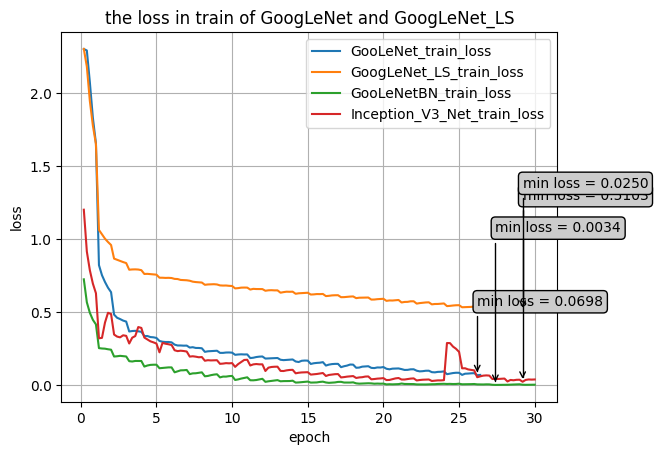

In [1]:
pth = '../data/ch07_output/'
from utlis import * 
import os
draw_figures(os.path.join(pth, 'ch7_04.csv'),
                [('GooLeNet_epoch_train', 'GooLeNet_train_loss'),
                 ('GoogLeNet_LS_epoch_train', 'GoogLeNet_LS_train_loss'),
                 ('GooLeNetBN_epoch_train', 'GooLeNetBN_train_loss'),
                 ('Inception_V3_Net_epoch_train', 'Inception_V3_Net_train_loss')],
                
                title='the loss in train of GoogLeNet and GoogLeNet_LS')

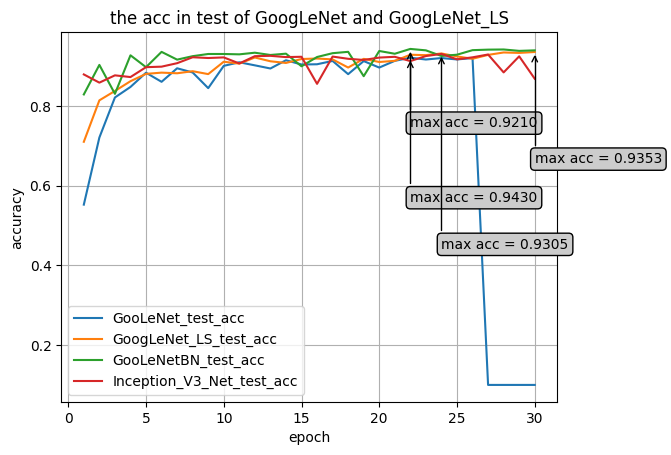

In [3]:
draw_figures(os.path.join(pth, 'ch7_04_eval.csv'),
                [('GooLeNet_epoch_test', 'GooLeNet_test_acc'),
                ('GoogLeNet_LS_epoch_test', 'GoogLeNet_LS_test_acc'),
                ('GooLeNetBN_epoch_test', 'GooLeNetBN_test_acc'),
                ('Inception_V3_Net_epoch_test', 'Inception_V3_Net_test_acc')],
                title='the acc in test of GoogLeNet and GoogLeNet_LS')

### 练习 7.4.2

使用GoogLeNet的最小图像大小是多少？

**解答：**

&emsp;&emsp;在原始论文中，论文使用的输入图像尺寸为224*224*3，这也是，目前深度神经网络常用的输入图像尺寸，但此尺寸并非网络能输入的最小尺寸，网络输入图像最小尺寸，往往指的是能够传入并训练的最好图像尺寸，最小尺寸保证了在网络传播的过程中，网络输出的W和H（即是输出的长和宽）不为零，这也是保证卷积正常进行的必要条件。


首先我们要明确影响输入图像尺寸大小的因素是什么，观察GoogLeNet，其中的Inception块并不改变图像尺寸（使用torchinfo可以进行验证）。

整个网络架构中，改变输入输出尺寸的为以下两部分：
* MaxPool2d模块，nn.MaxPool2d(kernel_size=3, stride=2, padding=1)，设输入尺寸为x， 输出尺寸尺寸缩减为$[\frac{x-1}{2} + 1]$，向上取整，为简便计算取$\frac{1}{2}$；
* 在网络起始的Conv2d模块：nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)这使得图像尺寸变为原来的$[[\frac{x-3}{2}]+1]$，向下取整,为简便计算取$\frac{1}{2}$。

网络中一共4层MaxPool2d模块，外加一开始的Conv2d模块，考虑MaxPool2d模块向上取整，网络尺寸需保证
$$
    \frac{x}{2^5} \gt \frac{1}{2}
$$

可以得到，GoogleNet最小输入图像尺寸为17*17。

虽然最小输入图像为17*17，但对于尺寸较小的图像，我们仍建议先将其放大到一定程度后再传入网络，过小的图像其中像素点过少，信息也较少，此时面对深度神经网络，一方面会造成网络的过拟合，同时也会浪费训练资源。



In [ ]:
import models
import torchinfo
GoogLeNet = models.GoogLeNet(3, 10)
torchinfo.summary(GoogLeNet, (1, 3, 17, 17))

### 练习 7.4.3

将AlexNet、VGG和NiN的模型参数大小与GoogLeNet进行比较。后两个网络架构是如何显著减少模型参数大小的？

**解答：**

&emsp;&emsp;NiN采用了全局平均池化，可以将卷积层的输出直接平均成一个数，从而减少了全连接层的参数数量。NiN还采用了1x1卷积，可以在不改变特征图大小的情况下改变特征图的深度，从而进一步减少了模型参数数量。

&emsp;&emsp;GoogLeNet使用了Inception块，可以通过并联的方式将不同的卷积层结合在一起，从而减少模型参数大小。



NiN：通过引入1x1卷积层代替全连接层，以及通过在卷积层中使用线性变换（1x1卷积）来增加非线性能力，从而减少参数。

GoogLeNet：通过使用Inception模块并行不同尺寸的卷积和池化操作，以及在网络末尾使用全局平均池化代替全连接层，显著减少了模型的参数。

## 7.5 批量规范化

### 练习 7.5.1

在使用批量规范化之前，我们是否可以从全连接层或卷积层中删除偏置参数？为什么？

**解答：**

&emsp;&emsp;可以。

&emsp;&emsp;首先我们需要明确全连接层或者卷积层中偏置参数的作用：其实在数学上，偏置参数是在通过网络后的输出结果上添加一非零常数。偏置项的作用主要有两点，其一是能够使得在整层输出为0的时候，保证输出仍非零，既增加了模型的灵活性，又能够很好地避免梯度消失；其二是能够改善模型的非线性特性，通过添加偏置项并配合非线性激活函数，能够较好地调整非线性函数的激活阈值，使得网络能够学习复杂、非线性的决策边界。


&emsp;&emsp;批量规范化是在网络的每个卷积层或全连接层之后，激活函数之前进行的一种操作，旨在改进训练过程，加快收敛速度，提高模型的稳定性。批量规范化的步骤包括以下几个关键点：
1. 对输出进行规范化；
规范化的公式表示如下：

$$
\begin{array}{l}
\begin{array}{l}
\mu_{\text {batch }}=\frac{1}{m} \sum_{i=1}^{m} x_{i} \\
\sigma_{\text {batch }}^{2}=\frac{1}{m} \sum_{i-1}^{m}\left(x_{i}-\mu_{\text {batch }}\right)^{2}
\end{array}\\
\hat{x}_{i}=\frac{x_{i}-\mu_{\text {batch }}}{\sqrt{\sigma_{\text {batch }}^{2}+\epsilon}}
\end{array}
$$
2. 对规范化后的数据，进行缩放（$\gamma$）和平移（$\beta$），两个缩放参数通过学习得到。

&emsp;&emsp;批量规范化中的平移参数β实际上可以承担原来层中偏置参数的角色。考虑到批量规范化的规范化步骤会消除输入数据的均值，原本的偏置项（如果存在）的效果会被这个规范化步骤抵消。因此，即使从全连接层或卷积层中删除了偏置项，批量规范化中的平移参数β也能够补偿这种变化，实现类似的效果。

### 练习 7.5.2

比较LeNet在使用和不使用批量规范化情况下的学习率。
1. 绘制训练和测试准确度的提高。
1. 学习率有多高？

**解答：**

首先加载必要的库、训练函数、绘图函数。

In [1]:
import torch
from torch import nn
from utlis import *
import models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from IPython.display import clear_output

pth = '../data/ch07_output/'
def train_models(net, 
                 train_loader, 
                 test_loader, 
                 epochs, 
                 lr, 
                 net_type : str =  None,
                 eval = True,
                 device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    # 设置优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 设置损失函数
    loss = nn.CrossEntropyLoss()
    # 初始化参数
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    
    # 使用列表记录输出数据
    epoch_list = []
    train_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(epochs):
    # 训练
        loss_sum = 0
        acc = 0
        net.train()
        for idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predict = net(x)
            l = loss(predict, y)
            l.backward()
            optimizer.step()
            
            loss_sum += l.item() * x.size(0)
            acc += predict.max(dim=1)[1].eq(y).sum().item()
            if (idx + 1) % (len(train_loader) // 5) == 0 or idx == len(train_loader) - 1:
                if (idx + 1) != len(train_loader):
                    loss_now = loss_sum / (idx + 1) / x.size(0)
                    acc_now = acc / (idx + 1) / x.size(0)
                else:
                    loss_now = loss_sum / len(train_loader.dataset)
                    acc_now = acc / len(train_loader.dataset)                
                train_acc.append(acc_now)
                train_loss.append(loss_now)
                epoch_list.append(epoch + (idx + 1) / len(train_loader))         
            
        # 测试
        if eval:
            loss_sum = 0
            acc = 0
            net.eval()
            with torch.no_grad():
                for idx, (x, y) in enumerate(test_loader):
                    x, y = x.to(device), y.to(device)
                    predict = net(x)
                    l = loss(predict, y)
                    
                    acc += predict.max(dim=1)[1].eq(y).sum().item()
                    
                acc /= len(test_loader.dataset)
                test_acc.append(acc)    
        epoch_test = list(range(1, int(epoch_list[-1]) + 1, 1))
    
    if net_type is not None:
        pth_csv1 = os.path.join(pth, 'ch7_05.csv')
        pth_csv2 = os.path.join(pth, 'ch7_05_eval.csv') 
    
        write2csv(pth_csv1, epoch_list, net_type + '_epoch_train')
        write2csv(pth_csv1, train_loss, net_type + '_train_loss')
        write2csv(pth_csv1, train_acc, net_type + '_train_acc')
        write2csv(pth_csv2, epoch_test, net_type + '_epoch_test')
        write2csv(pth_csv2, test_acc, net_type + '_test_acc')
    else:
        # print('net_type is None, don\'t record the data')
        
        return max(train_acc)

&emsp;&emsp; 批量标准化通过规范化层的输入来稳定和加速深度网络的训练。这减少了网络参数更新中的内部协变量偏移（internal covariate shift），即训练过程中每层输入分布的改变。因为每层的输入更加稳定，模型可以使用更高的学习率而不会导致梯度爆炸或消失的问题，

&emsp;&emsp; 学习率保持一致，都取$0.9$

In [2]:
LeNet = models.LeNet()
LeNet_BN = models.LeNet_BN()

batch_size, lr = 128, 0.9
train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size)

In [5]:
train_models(LeNet, train_loader, test_loader, epochs=20, lr=0.9, net_type='LeNet')
train_models(LeNet_BN, train_loader, test_loader, epochs=20, lr=0.9, net_type='LeNet_BN')

&emsp;&emsp;先来看不使用批量规范化的效果

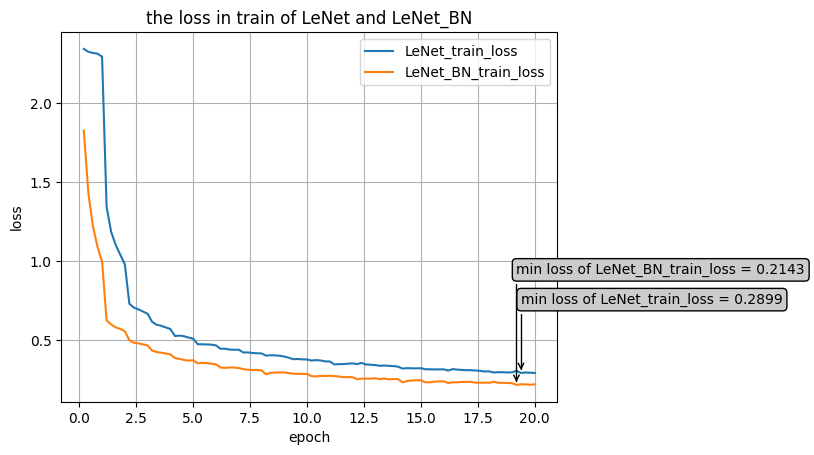

In [3]:
draw_figures(pth = os.path.join(pth, 'ch7_05.csv'), 
             label_list=[('LeNet_epoch_train', 'LeNet_train_loss'), 
                         ('LeNet_BN_epoch_train', 'LeNet_BN_train_loss')],
             title='the loss in train of LeNet and LeNet_BN')


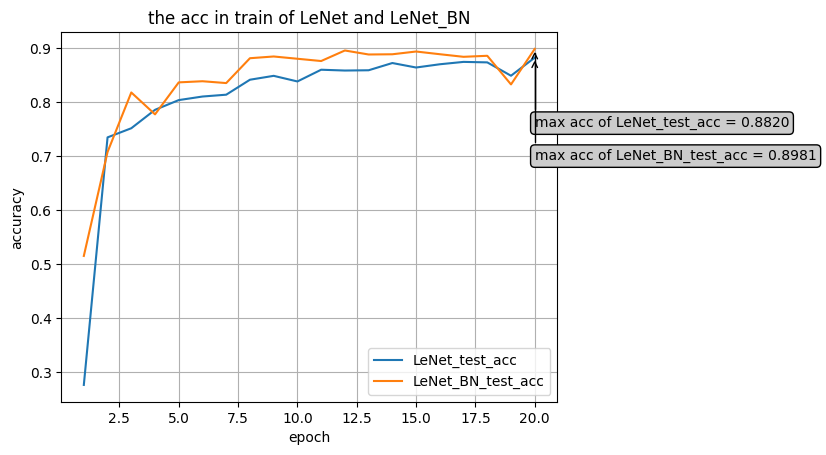

In [4]:
draw_figures(pth = os.path.join(pth, 'ch7_05_eval.csv'),
                label_list=[('LeNet_epoch_test', 'LeNet_test_acc'), 
                            ('LeNet_BN_epoch_test', 'LeNet_BN_test_acc')],
                title='the acc in train of LeNet and LeNet_BN')

In [13]:
max_acc_LeNet = []
lr_list = [0.7 + i * 0.1 * 0.2 for i in range(int((10 - 1) / 0.5) + 1)]
for lr in lr_list:
    acc = train_models(LeNet, train_loader, test_loader, epochs=20, lr=lr)
    max_acc_LeNet.append(acc)
    print('lr is:', lr, 'acc is:', acc)
clear_output()
print('max_acc_LeNet:', max_acc_LeNet)

max_acc_LeNet: [0.8731098790322581, 0.8788138440860215, 0.8800403225806451, 0.8781502016129032, 0.8723958333333334, 0.880880376344086, 0.8689333333333333, 0.8702326948924731, 0.8695116487455197, 0.8178666666666666, 0.8684475806451613, 0.8812163978494624, 0.7867333333333333, 0.8552587365591398, 0.8282930107526881, 0.8771841397849462, 0.10556675627240143, 0.8493153561827957, 0.8387096774193549]


In [17]:
max_acc_LeNet_BN = []
lr_list = [0.7 + i * 0.1 * 0.2 for i in range(int((10 - 1) / 0.5) + 1)]
for lr in lr_list:
    acc = train_models(LeNet_BN, train_loader, test_loader, epochs=20, lr=lr)
    max_acc_LeNet_BN.append(acc)
    print('lr is:', lr, 'acc is:', acc)
clear_output()
print('max_acc_LeNet_BN:', max_acc_LeNet_BN)

max_acc_LeNet_BN: [0.9187668010752689, 0.924815188172043, 0.9180527553763441, 0.9226310483870968, 0.9263272849462365, 0.9187387992831542, 0.9268313172043011, 0.9236951164874552, 0.9240591397849462, 0.9225470430107527, 0.9215599798387096, 0.922883064516129, 0.9255712365591398, 0.9227150537634409, 0.9240591397849462, 0.9201333333333334, 0.9211189516129032, 0.926747311827957, 0.922883064516129]


In [10]:
np.argmax(max_acc_LeNet)

11

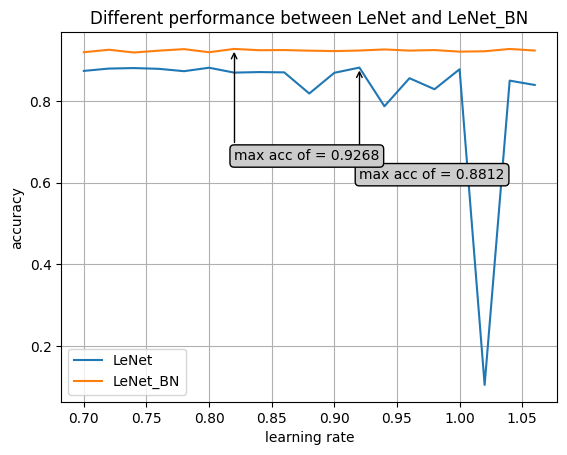

In [12]:
lr_list = [0.7 + i * 0.1 * 0.2 for i in range(int((10 - 1) / 0.5) + 1)]
max_acc_LeNet = [0.8731098790322581, 0.8788138440860215, 0.8800403225806451, 0.8781502016129032, 0.8723958333333334, 0.880880376344086, 0.8689333333333333, 0.8702326948924731, 0.8695116487455197, 0.8178666666666666, 0.8684475806451613, 0.8812163978494624, 0.7867333333333333, 0.8552587365591398, 0.8282930107526881, 0.8771841397849462, 0.10556675627240143, 0.8493153561827957, 0.8387096774193549]
max_acc_LeNet_BN=[0.9187668010752689, 0.924815188172043, 0.9180527553763441, 0.9226310483870968, 0.9263272849462365, 0.9187387992831542, 0.9268313172043011, 0.9236951164874552, 0.9240591397849462, 0.9225470430107527, 0.9215599798387096, 0.922883064516129, 0.9255712365591398, 0.9227150537634409, 0.9240591397849462, 0.9201333333333334, 0.9211189516129032, 0.926747311827957, 0.922883064516129]

plt.plot(lr_list, max_acc_LeNet, label='LeNet')
plt.plot(lr_list, max_acc_LeNet_BN, label='LeNet_BN')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.title('Different performance between LeNet and LeNet_BN')
plt.legend()
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90,rad=10")
plt.annotate(('max acc of = {:.4f}'.format(max_acc_LeNet[np.argmax(max_acc_LeNet)])),
             (lr_list[np.argmax(max_acc_LeNet)], max_acc_LeNet[np.argmax(max_acc_LeNet)]), xytext=(0, -80), textcoords='offset points',
             bbox=bbox, arrowprops=arrowprops)
plt.annotate(('max acc of = {:.4f}'.format(max_acc_LeNet_BN[np.argmax(max_acc_LeNet_BN)])),
             (lr_list[np.argmax(max_acc_LeNet_BN)], max_acc_LeNet_BN[np.argmax(max_acc_LeNet_BN)]), xytext=(0, -80), textcoords='offset points',
             bbox=bbox, arrowprops=arrowprops)
plt.grid()
plt.show()

&emsp;&emsp;再来看使用批量规范化的效果

### 练习 7.5.3

我们是否需要在每个层中进行批量规范化？尝试一下？

**解答：**

&emsp;&emsp; 一般来说，`BatchNorm`可以在卷积层和全连接层之间使用，也可以在激活函数之前或之后使用。但是，并不是所有的层都需要使用`BatchNorm`，有时候使用过多的BatchNorm反而会降低模型性能。


In [3]:
LeNet_BN2 = models.LeNet_BN2()
LeNet_all_BN = models.LeNet_all_BN()

batch_size, lr = 128, 0.9
train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size)
train_models(LeNet_BN2, train_loader, test_loader, epochs=20, lr=0.9, net_type='LeNet_BN2')
train_models(LeNet_all_BN, train_loader, test_loader, epochs=20, lr=0.9, net_type='LeNet_all_BN')

In [6]:
train_models(LeNet_all_BN, train_loader, test_loader, epochs=20, lr=0.9, net_type='LeNet_all_BN')

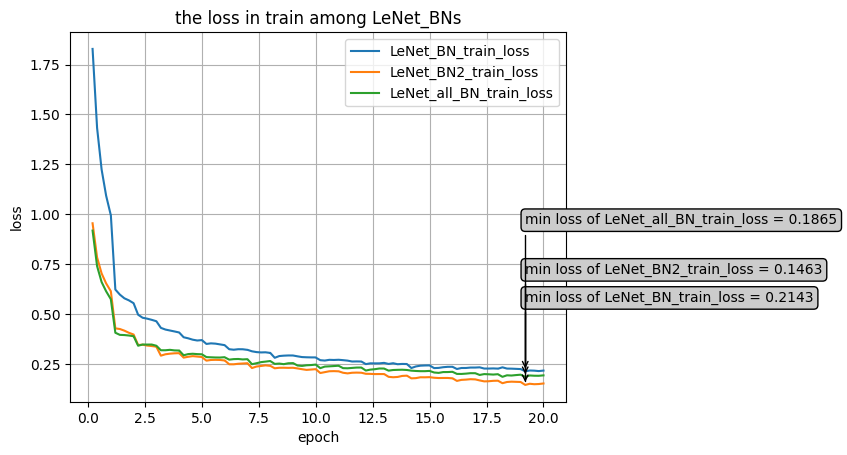

In [13]:
draw_figures(pth = os.path.join(pth, 'ch7_05.csv'),
             label_list=[('LeNet_BN_epoch_train', 'LeNet_BN_train_loss'),
                         ('LeNet_BN2_epoch_train', 'LeNet_BN2_train_loss'), 
                         ('LeNet_all_BN_epoch_train', 'LeNet_all_BN_train_loss')],
             title='the loss in train among LeNet_BNs')

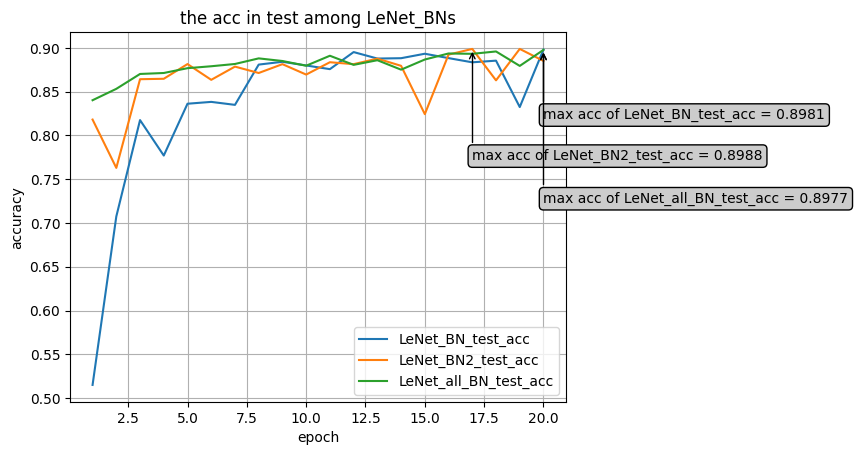

In [14]:

draw_figures(pth = os.path.join(pth, 'ch7_05_eval.csv'),
             label_list=[('LeNet_BN_epoch_test', 'LeNet_BN_test_acc'),
                         ('LeNet_BN2_epoch_test', 'LeNet_BN2_test_acc'), 
                         ('LeNet_all_BN_epoch_test', 'LeNet_all_BN_test_acc')],
             title='the acc in test among LeNet_BNs')

### 练习 7.5.4

可以通过批量规范化来替换暂退法吗？行为会如何改变？

**解答：**

&emsp;&emsp;可以。但一般是直接进行替换，但一般不会同时用。

&emsp;&emsp;首先我们要明确批量规范化和暂退法的实现形式与作用：
* 批量规范化（Batch Normalization）：通过对每个小批量数据进行规范化处理，使得输出具有固定的均值和方差。这通常可以让模型使用更高的学习率而不会发生梯度消失或梯度爆炸，其能够减少内部协变量偏移（Internal Covariate Shift），即随着训练进展，网络层输入分布改变，但不至于产生过分的偏差。
* 暂退法（Dropout）：在训练过程中，随机选择一部分神经元并将它们的输出置为0，可以看作是在训练多个不同的网络并在测试时进行平均。减少模型对训练数据的过拟合。通过在训练过程中随机“丢弃”一些神经元的输出，可以迫使网络学习更加鲁棒的特征，不过分依赖于任何一个神经元。

&emsp;&emsp;因此在一定程度上，可以通过批量规范化来替换暂退法，这两者都能够起到正则化的效果。这两种技术解决问题的角度不同，批量规范化通过**规范化层输入**来加速训练和提高稳定性，而暂退法通过**随机化**的方式来增强模型的泛化能力。

&emsp;&emsp;但目前，两种方法在实践中往往均需要应用，一方面批量规范化可以使得梯度下降过程更加稳定，而暂退法能够较有效地解决过拟合的问题。在实践中，一种常见的方法是在卷积层之后使用批量规范化，在全连接层之前使用暂退法。

&emsp;&emsp;我们可以通过下面的例子来观察两种方法的具体效果。

In [11]:
dropout = nn.Dropout(0.5)
batchnorn = nn.BatchNorm2d(1)

x = torch.rand(1, 1, 3, 3)
print('origin input: ',x)
print('the mean and std of x: ',x.mean(), x.std())
output_bn = batchnorn(x)
print('output_bn is: ', output_bn)
print('the mean and std of output_bn: ', output_bn.mean(), output_bn.std())
output_dr = dropout(x)
print('output_dr is: ', output_dr)
print('the mean and std of output_dr: ', output_dr.mean(), output_dr.std())


origin input:  tensor([[[[0.9614, 0.2732, 0.5448],
          [0.5254, 0.6599, 0.8698],
          [0.9161, 0.6309, 0.1269]]]])
the mean and std of x:  tensor(0.6120) tensor(0.2841)
output_bn is:  tensor([[[[ 1.3040, -1.2649, -0.2509],
          [-0.3232,  0.1788,  0.9622],
          [ 1.1349,  0.0704, -1.8112]]]], grad_fn=<NativeBatchNormBackward0>)
the mean and std of output_bn:  tensor(2.6491e-08, grad_fn=<MeanBackward0>) tensor(1.0606, grad_fn=<StdBackward0>)
output_dr is:  tensor([[[[1.9227, 0.5464, 1.0896],
          [1.0509, 1.3198, 1.7396],
          [0.0000, 1.2618, 0.0000]]]])
the mean and std of output_dr:  tensor(0.9923) tensor(0.6878)


### 练习 7.5.5

确定参数`beta`和`gamma`，并观察和分析结果。

**解答：**

Fix the parameters beta and gamma. Observe and analyze the results.

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 限制X的维度
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims, freeze=False):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        self.freeze = freeze
            
        

    def forward(self, X):
        if self.freeze:
            m = 1.0
        else:
            m = 0.9
        # 如果X不在显存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=m)
        return Y

In [3]:
LeNet_BN2_freeze = models.LeNet_BN2_freeze()
LeNet_BN_freeze = models.LeNet_BN_freeze()

batch_size, lr = 128, 0.9
train_loader, test_loader = load_data_fashion_mnist(batch_size=batch_size)

train_models(LeNet_BN2_freeze, train_loader, test_loader, epochs=20, lr=0.9, net_type='LeNet_BN2_freeze')
train_models(LeNet_BN_freeze, train_loader, test_loader, epochs=20, lr=0.9, net_type='LeNet_BN_freeze')

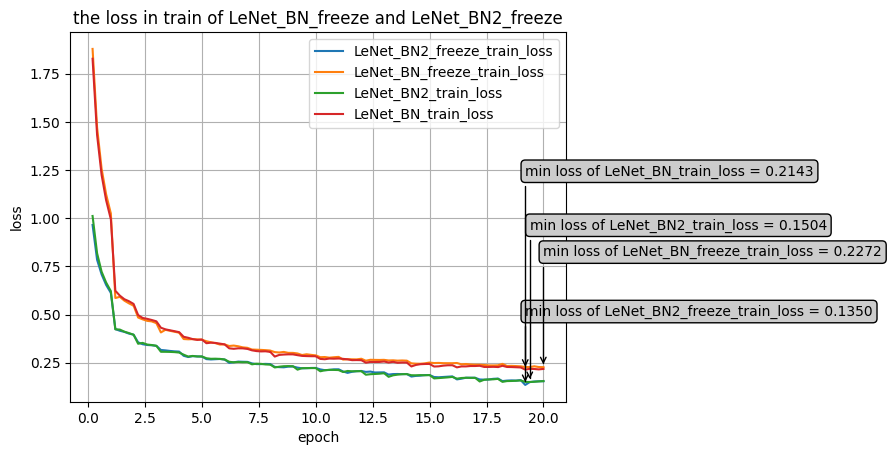

In [4]:
draw_figures(pth = os.path.join(pth, 'ch7_05.csv'),
                label_list=[('LeNet_BN2_freeze_epoch_train', 'LeNet_BN2_freeze_train_loss'),
                            ('LeNet_BN_freeze_epoch_train', 'LeNet_BN_freeze_train_loss'),
                            ('LeNet_BN2_epoch_train', 'LeNet_BN2_train_loss'),
                            ('LeNet_BN_epoch_train', 'LeNet_BN_train_loss')],
                title='the loss in train of LeNet_BN_freeze and LeNet_BN2_freeze')

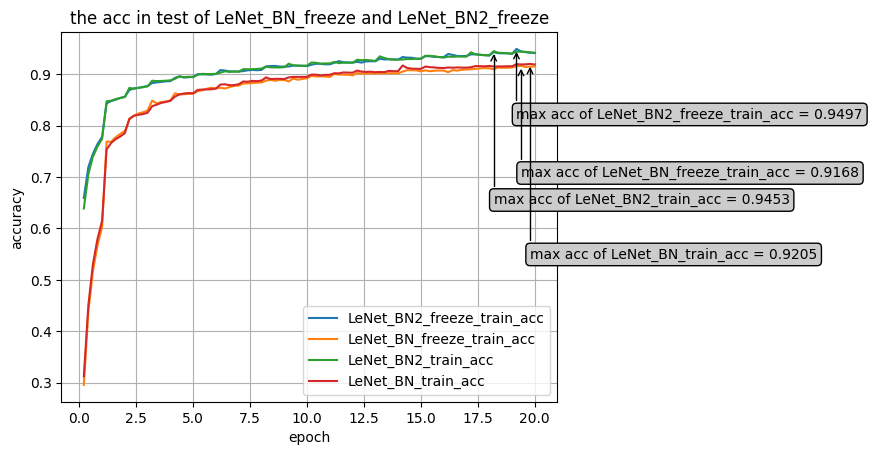

In [5]:
draw_figures(pth = os.path.join(pth, 'ch7_05.csv'),
                label_list=[('LeNet_BN2_freeze_epoch_train', 'LeNet_BN2_freeze_train_acc'),
                            ('LeNet_BN_freeze_epoch_train', 'LeNet_BN_freeze_train_acc'),
                            ('LeNet_BN2_epoch_train', 'LeNet_BN2_train_acc'),
                            ('LeNet_BN_epoch_train', 'LeNet_BN_train_acc')],
                title='the acc in test of LeNet_BN_freeze and LeNet_BN2_freeze')

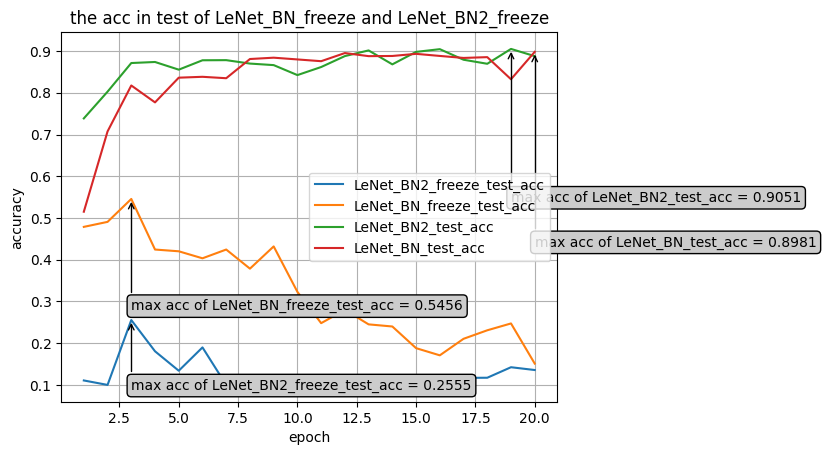

In [6]:
draw_figures(pth = os.path.join(pth, 'ch7_05_eval.csv'),
                label_list=[('LeNet_BN2_freeze_epoch_test', 'LeNet_BN2_freeze_test_acc'),
                            ('LeNet_BN_freeze_epoch_test', 'LeNet_BN_freeze_test_acc'),
                            ('LeNet_BN2_epoch_test', 'LeNet_BN2_test_acc'),
                            ('LeNet_BN_epoch_test', 'LeNet_BN_test_acc')],
                title='the acc in test of LeNet_BN_freeze and LeNet_BN2_freeze')

### 练习 7.5.6

查看高级API中有关`BatchNorm`的在线文档，以查看其他批量规范化的应用。

**解答：**

&emsp;&emsp; [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html?highlight=batchnorm#torch.nn.BatchNorm1d)
`BatchNorm1d`用于规范化一维数据，通常应用于全连接层的输出上。其期望输入的形状为(N, C, L)，其中N是批量大小，C是通道数，L是特征数量。


&emsp;&emsp; [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)
`BatchNorm2d`用于规范化图像数据或二维数据，常用于卷积层之后。其期望输入的形状为(N, C, H, W)，其中N是批量大小，C是通道数，H是高度，W是宽度。

&emsp;&emsp; [BatchNorm3d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm3d.html?highlight=batchnorm#torch.nn.BatchNorm3d)
`BatchNorm3d`用于规范化三维数据，常用于三维卷积层之后处理视频或体积数据。其期望输入的形状为(N, C, D, H, W)，其中N是批量大小，C是通道数，D是深度，H是高度，W是宽度。

&emsp;&emsp; [LazyBatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.LazyBatchNorm1d.html?highlight=batchnorm#torch.nn.LazyBatchNorm1d); [LazyBatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.LazyBatchNorm2d.html?highlight=batchnorm#torch.nn.LazyBatchNorm2d); [LazyBatchNorm3d](https://pytorch.org/docs/stable/generated/torch.nn.LazyBatchNorm3d.html?highlight=batchnorm#torch.nn.LazyBatchNorm3d)


&emsp;&emsp;`LazyBatchNorm`层允许用户在定义层时不指定通道数。这个层会在第一次执行前向传播时，根据输入数据自动推断通道数，并据此初始化相关参数（如权重和偏置）。这种延迟初始化方式使得模型能够更加动态地适应不同的输入数据结构。这对于开发通用模型库或进行探索性研究特别有用，因为可以减少重复修改模型结构的工作量。

&emsp;&emsp; [SyncBatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.SyncBatchNorm.html#syncbatchnorm)`SyncBatchNorm`用于多GPU训练场景。在深度学习训练中，尤其是当使用数据并行来加速训练时，标准的批量规范化层只在每个GPU上独立地计算其所处理的批次数据的统计量（即均值和方差）。这种方式可能会因为每个GPU上的批次大小较小而导致统计量估计不准确，特别是在高度并行化时。`SyncBatchNorm`通过跨所有参与训练的GPU同步这些统计量的计算，以解决这一问题。


### 练习 7.5.7

研究思路：可以应用的其他“规范化”转换？可以应用概率积分变换吗？全秩协方差估计可以么？

**解答：**

&emsp;&emsp; 除了BatchNorm，还有以下一些常用的规范化技术：

&emsp;&emsp; 1. `LayerNorm`: 对单个样本的所有神经元进行规范化，而不是BatchNorm中的样本批次。对于RNN特别有用。

&emsp;&emsp; 2. `InstanceNorm`: 主要用于样式转换任务。

&emsp;&emsp; 3. `GroupNorm`: 把通道分为几个组，并对每一组进行规范化。

&emsp;&emsp; 以上方法的核心思想是进行归一化操作，以确保输入值的分布在经过激活函数之前保持相对稳定。

&emsp;&emsp; 概率积分变换：它是一种将任意分布转换为均匀分布的方法。虽然它在统计学中被广泛使用，但在深度学习中不太常见，主要是因为它通常需要知道数据的分布或者需要一个非参数方法来估计这个变换，这在神经网络任务中可能是不实际的。

&emsp;&emsp; 全秩协方差估计：在深度学习中直接使用全秩协方差估计进行规范化是不常见的，主要是因为计算和存储开销可能非常大，特别是对于神经网络。但是，有些方法可能会利用协方差的某些性质或简化版本。例如，`Whitening`操作就是基于协方差矩阵的。


## 7.6 残差网络（ResNet）

In [ ]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.015, train acc 0.996, test acc 0.919
1585.4 examples/sec on cuda:0


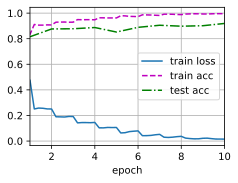

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习 7.6.1

图7-5中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？

**解答：**

&emsp;&emsp;它们的主要区别在于：
* Inception块是由多个不同大小的卷积核组成的，可以在同一层上获得稀疏或非稀疏的特征，然后将其进行合并；

* 残差块则是通过添加跨层连接来解决深度神经网络中的梯度消失问题。

&emsp;&emsp;当删除了Inception块中的一些路径之后，基本可以看到Inception块和残差块是相似的：当Inception块被简化为只含有一路卷积操作和一个直接的跳跃连接时。这种简化的Inception块基本近似于残差块的结构。

&emsp;&emsp;通过对Inception块的线路简化和修改，它们之间可以展现出一定的相似性。

### 练习 7.6.2

参考ResNet论文中的表1，以实现不同的变体。

**解答：**

&emsp;&emsp;论文中的表格如下，表格中给出了五种层数不尽相同的ResNet变体，

<img src = ..\..\images\ch07_1_3_resnet.png style="zoom:80%" title="ResNet Varient">

&emsp;&emsp;这些变体的基本组成块分别是论文中提到的BasicBlock以及BottleNeck，其结构如下：

<img src = ..\..\images\ch07_1_4_structure.png style="zoom:100%" title="BasicBlock and BottleNeck">

&emsp;&emsp;在`models.py`文件中，给出了不同的ResNet结构实现，下面给出代码：

In [ ]:
import torch
from typing import Callable, List, Optional, Type, Union
import torch.nn.functional as F
# 3x3卷积核的网络结构
def conv3x3(inplanes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(inplanes, 
                     out_planes, 
                     kernel_size=3, 
                     stride=stride, 
                     padding=1, 
                     bias=False)
# 构建Resnet模型，按照源代码，先构建BasicBlock，Bottleneck两个模块

class BasicBlock(nn.Module):
    expansion: int = 1  # 对输出通道进行倍增
    def __init__(self, 
                 inplanes: int,
                 planes: int,
                 stride: int = 1):
        super().__init__()
        
        
        # 此处3x3卷积层的操作遵循原始代码的操作
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        # 没有stride
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        # 对齐shortcut
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # prepare the identity for shortcut
        identity = x
        # 第一个卷积层
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        # 第二个卷积层
        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out
    

class Bottleneck(nn.Module):
    
    expansion: int = 4  # 对输出通道进行倍增
    
    def __init__(self,
                 inplanes: int,
                 planes: int,
                 stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) 
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        out += self.shortcut(identity)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, 
                 in_channels,
                 block: Type[Union[BasicBlock, Bottleneck]],
                 layers: List[int],
                 num_classes: int = 100):
        super().__init__()
        
        self.inplanes = 64
        # 这里进行了一点小改动：
        # 统一采样3x3卷积层，去掉这里的maxpooling
        self.conv1 = conv3x3(in_channels, 64)   # rgb, out = channels=64, stride=0
        self.bn1 = nn.BatchNorm2d(64)
        
        
        # 层次化设计
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)  # 对应着conv2_x
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # 对应着conv3_x
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # 对应着conv4_x
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # 对应着conv5_x
        
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        

        
    def _make_layer(self,
                    block: Type[Union[BasicBlock, Bottleneck]],
                    planes: int,  # 输入的通道
                    blocks: int, # 模块数目
                    stride: int = 1, # 步长
                    ) -> nn.Sequential:
        # 除了第一个stride由stride决定，其余都是1
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inplanes, planes, stride))
            self.inplanes = planes * block.expansion
            
        # 传入layers的列表进入Sequential，并进行拆分成逐元素输入Sequential
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x= self.conv1(x)
        x = self.bn1(x)
        out = F.relu(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # 直接进行平均池化
        out = F.avg_pool2d(out, 4)
        # 拉成一维
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out    
    
def ResNet18(num_classes=10):
    return ResNet(3, BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(3, BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(3, Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(3, Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(3, Bottleneck, [3,8,36,3], num_classes)

### 练习 7.6.3

对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请试着去实现它。

**解答：**

&emsp;&emsp; 在一题中已经完成定义，此处不再赘述。

### 练习 7.6.4

在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请尝试做这个改进。详见参考文献[57]中的图1。

**解答：**

In [ ]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = self.conv1(F.relu(self.bn1(X)))
        Y = self.conv2(F.relu(self.bn2(Y)))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return Y

### 练习 7.6.5

为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？

**解答：**

&emsp;&emsp;函数类是嵌套的，顾名思义，就是指一个函数类是另一个函数类的子集，在函数类嵌套的情况下，我们仍然要限制增加函数的复杂性，主要有以下两点原因：

1. 复杂的模型需要更多的计算资源进行训练和推理。这包括更长的训练时间、更高的内存需求和更大的能耗。在有限的资源下，过于复杂的模型可能不切实际；同时模型复杂度增加，会使得训练过程更加不稳定，收敛速度大大降低。
2. 更复杂的模型能够在训练数据上获得更低的误差，但这往往伴随着在未见数据上表现较差的风险，此时往往会产生过拟合。因此简化模型复杂度能够平衡模型拟合性能。

## 7.7 稠密连接网络（DenseNet）

In [6]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X

def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [7]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
              lr=0.1, num_classes=10):
        super(DenseNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, growth_rate))
            num_channels += num_convs * growth_rate
            if i != len(arch) - 1:
              num_channels //= 2
              self.net.add_module(f'tran_blk{i+1}', transition_block(
                  num_channels))
        self.net.add_module('last', nn.Sequential(
          nn.LazyBatchNorm2d(), nn.ReLU(),
          nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
          nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)

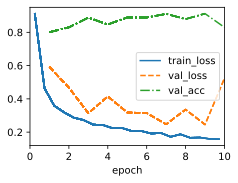

In [ ]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

### 练习 7.7.1

为什么我们在过渡层使用平均汇聚层而不是最大汇聚层？

**解答：**

&emsp;&emsp; 因为平均汇聚层可以更好地保留特征图中的信息，而最大汇聚层会丢失一些信息。

### 练习 7.7.2

DenseNet的优点之一是其模型参数比ResNet小。为什么呢？

**解答：**

&emsp;&emsp; 因为DenseNet中每个卷积层的输入都是前面所有层的输出的拼接，而不是像ResNet一样只是前面一层的输出。这种设计使得DenseNet中每个卷积层的输入通道数比ResNet少很多，因此DenseNet中的BN层参数也会少很多，全连接层的参数也比ResNet少很多。

### 练习 7.7.3

DenseNet一个诟病的问题是内存或显存消耗过多。
1. 真的是这样吗？可以把输入形状换成$224 \times 224$，来看看实际的显存消耗。
2. 有另一种方法来减少显存消耗吗？需要改变框架么？

**解答：**

**问题1**

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

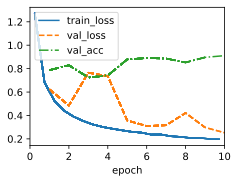

In [9]:
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
model = DenseNet(lr=0.01)
trainer_224 = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer_224.fit(model, data)
memory_stats = torch.cuda.memory_stats(device='cuda')

In [13]:
print("显存消耗为", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("内存消耗为", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

显存消耗为 4158.44775390625 MB
内存消耗为 46.6328125 MB


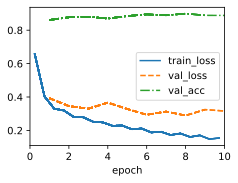

In [16]:
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
model = DenseNet(lr=0.01)
trainer_32 = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(32, 32))
trainer_32.fit(model, data)
memory_stats = torch.cuda.memory_stats(device='cuda')

In [17]:
print("显存消耗为", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("内存消耗为", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

显存消耗为 318.5234375 MB
内存消耗为 74.71142578125 MB


**问题2**

**解答：**

&emsp;&emsp; 除了减小输入张量的大小，以下策略也可能有助于减少网络的显存消耗：

&emsp;&emsp; 1. 减少网络复杂性：可通过减小DenseNet网络中层的数量，或者减小每层中的神经元数量来实现。例如，您可以选择小一些的DenseNet结构（如DenseNet121），或者自定义一个更小的DenseNet。但是请注意，这样做可能会影响网络的性能。

&emsp;&emsp; 2. 采用模型压缩技术：模型压缩技术如权重量化、知识蒸馏等可以有效地减少网络对显存的需求，且通常能保持原始网络的性能。

&emsp;&emsp; 3. 改变优化器：一些优化器例如Adam，由于存储了大量的梯度信息，可能会导致显存使用增加。使用像SGD这样的优化器可能对显存需求更小。

&emsp;&emsp; 4. 混合精度训练：混合精度训练是一种在训练过程中同时使用float32和float16数据类型的方法，能够有效节省显存消耗，同时一般不会对模型精度产生太大影响。需要注意的是，硬件必须支持float16运算。

&emsp;&emsp; 5. 梯度累积：在PyTorch等框架中，可以利用梯度累积技术减小batch size，每次前向传播计算得到梯度后并不立即更新参数，而是累积几次梯度后再更新，这样可以在不损失模型性能的情况下有效降低显存占用。

&emsp;&emsp; 通常情况下，无需因此改变框架。

### 练习 7.7.4

实现DenseNet论文[71]表1所示的不同DenseNet版本。

**解答：**

In [18]:
class DenseNet(nn.Module):
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4), num_classes=10):
        super(DenseNet, self).__init__()

        self.b1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.net = [self.b1]

        for i, num_convs in enumerate(arch):
            self.net.append(DenseBlock(num_convs, growth_rate))
            num_channels += num_convs * growth_rate
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.append(transition_block(num_channels))

        self.net.append(nn.Sequential(
            nn.BatchNorm2d(num_channels), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(num_channels, num_classes)))

        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)

def densenet(arch_name):
    arch_layers = {
        'densenet121': [6, 12, 24, 16],
        'densenet169': [6, 12, 32, 32],
        'densenet201': [6, 12, 48, 32],
    }
    return DenseNet(arch=arch_layers[arch_name])

# 使用示例
net = densenet('densenet121')
print(net)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


DenseNet(
  (b1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): DenseBlock(
      (net): Sequential(
        (0): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, tr

### 练习 7.7.5

应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于4.10节中的房价预测任务。

**解答：**

&emsp;&emsp;在4.10节中的房价预测任务为传统的机器学习任务，下面给出任务的实现流程：
&emsp;&emsp;首先加载必要的库：

In [1]:
# %matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

&emsp;&emsp;构建房价预测数据集：

In [2]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            # 数据集不存在时，下载并预处理数据集
            # 下面给出的为训练集与测试集都下载地址
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
    
    # 该函数用于预处理数据集
    def preprocess(self):
      # 移除 ID 以及 SalePrice 两列,然后进行合并
      label = 'SalePrice'
      features = pd.concat(
          (self.raw_train.drop(columns=['Id', label]),
          self.raw_val.drop(columns=['Id'])))
      # 对连续数值列进行标准化
      numeric_features = features.dtypes[features.dtypes!='object'].index
      features[numeric_features] = features[numeric_features].apply(
          lambda x: (x - x.mean()) / (x.std()))
      
      # 使用0代替缺失值
      features[numeric_features] = features[numeric_features].fillna(0)
      # 使用one-hot编码来代替离散值
      features = pd.get_dummies(features, dummy_na=True)
      # Save preprocessed features
      self.train = features[:self.raw_train.shape[0]].copy()
      # 添加 SalePrice 列
      self.train[label] = self.raw_train[label]
      self.val = features[self.raw_train.shape[0]:].copy()
    
    # 生成迭代器
    def get_dataloader(self, train):
      label = 'SalePrice'
      data = self.train if train else self.val
      if label not in data: return
      
      # lambda 函数用于将数据转换为float32张量   
      get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                        dtype=torch.float32)
      # 将价格函数取对数并变换为列向量
      tensors = (get_tensor(data.drop(columns=[label])),  # X
                torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
      # 将tensor以(x, y)的形式传入
      return self.get_tensorloader(tensors, train)

In [3]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [4]:
# 处理数据
data.preprocess()

data.train.shape, data.val.shape

((1460, 331), (1459, 330))

&emsp;&emsp;在训练过程，进行K折交叉验证。

In [5]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        
        # 构建交叉验证集
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets


def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
        
    print(f'交叉验证平均预测均方误差 = {sum(val_loss)/len(val_loss)}')
    return models



&emsp;&emsp;构建训练集，进行交叉验证：

d:\Program\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
d:\Program\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
d:\Program\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
d:\Program\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy dev

交叉验证平均预测均方误差 = 0.06712815091013909


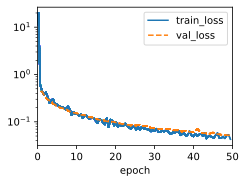

In [6]:
trainer = d2l.Trainer(max_epochs=50)
models = k_fold(trainer, data, k=5, lr=0.01)
# validate(models, data.val)

&emsp;&emsp;构造基于`DenseNet`的多层感知机以及交叉验证函数:

In [9]:



def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = HouseDenMLP(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'交叉验证平均预测均方误差 = {sum(val_loss)/len(val_loss)}')
    return models

class HouseDenMLP(d2l.LinearRegression):
    def __init__(self, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.p0 = nn.Flatten()
        self.p1 = nn.Sequential(nn.LazyLinear(64),
                    nn.LazyBatchNorm1d(),
                    nn.ReLU(),
                    nn.Dropout(0.05))
        self.p2 = nn.Sequential(nn.LazyLinear(32),
                    nn.LazyBatchNorm1d(),
                    nn.ReLU(),
                    nn.Dropout(0.05))
        self.p3 = nn.Sequential(nn.LazyLinear(16),
                    nn.LazyBatchNorm1d(),
                    nn.ReLU(),
                    nn.Dropout(0.05))
        self.net = nn.Sequential(self.p1,
                    self.p2,
                    self.p3,
                    nn.LazyLinear(1))

    def forward(self, X):
        X = self.net[0](X)
        for blk in self.net[1:-1]:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return self.net[-1](X)


d:\Program\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
d:\Program\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
d:\Program\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
d:\Program\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy dev

交叉验证平均预测均方误差 = 0.06601933524012565


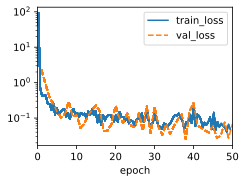

In [13]:
# net = HouseDenMLP(lr=0.05)

trainer = d2l.Trainer(max_epochs=50)
models = k_fold(trainer, data, k=5, lr=0.06)